# Compute transition numbers for green, brown and neutral occupations without education etc. constraints
Felix Zaussinger | 20.08.2021

## Core Analysis Goal(s)
1. Map transition pathways based on new G/B/N classification and other proxies

## Key Insight(s)
1.

In [1]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper")
#sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

ESCO data set components

In [3]:
occ = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupations_en.csv"))
skill_groups = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skillGroups_en.csv"))
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))
occ_skills_mapping = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupationSkillRelations.csv"))

In [4]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA_gbn.csv"),
    index_col=0
)

#df_metadata = df_metadata.set_index("id")
df_metadata
#df_metadata.greenness_vona_2018_v2 = df_metadata.greenness_vona_2018_v2.fillna(0)

# convert job zone to categorical var
#df_metadata.job_zone = pd.Categorical(df_metadata.job_zone, ordered=True)
#df_metadata.isco_level_1 = pd.Categorical(df_metadata.isco_level_1, ordered=False)
#df_metadata.isco_level_2 = pd.Categorical(df_metadata.isco_level_2, ordered=False)

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce,is_brown,is_green,is_neutral
0,0,http://data.europa.eu/esco/occupation/00030d09...,technical director,2166,27-1011.00,art directors,2,21,216,Non Green,NaN,NaN,NaN,NaN,0.0000,36.670202,37555.308176,NaN,NaN,4.0,6.2477,8.0309,4.3843,H,500000.0,263000.0,-253000.0,-500000.0,10000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,True
1,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,51-4021.00,"extruding and drawing machine setters, operato...",8,81,812,Non Green,NaN,NaN,NaN,NaN,0.0000,39.904110,22031.963636,0.000020,645.0,2.0,2.1163,2.4383,3.6486,M,339000.0,712000.0,-34000.0,-339000.0,678000.0,2913000.0,500.0,-5589000.0,-2913000.0,-5588500.0,True,False,False
2,2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7543,51-9061.00,"inspectors, testers, sorters, samplers, and we...",7,75,754,Green Enhanced Skills,2.0,0.0,30.0,0.066667,0.0625,38.709386,22430.367647,NaN,NaN,2.0,2.5397,4.8863,4.0288,M,48000.0,316000.0,-500.0,-48000.0,315500.0,1315000.0,408000.0,-440000.0,-1315000.0,-32000.0,False,True,False
3,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,17-3023.01,electronics engineering technicians,3,31,315,Non Green,NaN,NaN,NaN,NaN,0.0000,42.036716,32754.000000,0.000087,2797.0,3.0,4.3848,5.4808,4.0782,H,748000.0,528000.0,-206000.0,-748000.0,322000.0,3042000.0,1225000.0,-965000.0,-3042000.0,260000.0,False,False,True
4,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,13-1161.00,market research analysts and marketing special...,2,24,243,Non Green,NaN,NaN,NaN,NaN,0.0000,36.354676,38839.816377,0.000648,20834.0,4.0,6.8261,6.3481,3.8265,H,218000.0,147000.0,-75000.0,-218000.0,72000.0,823000.0,837000.0,-53000.0,-823000.0,784000.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,15-2041.00,statisticians,2,21,212,Non Green,NaN,NaN,NaN,NaN,0.0000,35.494487,36135.290249,0.000286,9184.0,5.0,8.3000,5.5000,4.6000,H,500000.0,263000.0,-253000.0,-500000.0,10000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,True
2917,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,51-9199.01,recycling and reclamation workers,9,96,961,New Green N&E,18.0,0.0,0.0,1.000000,1.0000,39.443972,21357.054545,0.000417,13414.0,2.0,3.1532,3.3559,2.8314,L,153000.0,305000.0,-17000.0,-153000.0,288000.0,860000.0,1152000.0,-111000.0,-860000.0,1041000.0,False,True,False
2918,2939,http://data.europa.eu/esco/occupation/ffa4dd5d...,armoured car guard,5414,33-9032.00,security guards,5,54,541,Non Green,NaN,NaN,NaN,NaN,0.0000,37.021429,24315.540984,NaN,NaN,2.0,2.2215,3.2642,2.0230,M,141000.0,179000.0,-27000.0,-141000.0,152000.0,744000.0,579000.0,-497000.0,-744000.0,82000.0,False,False,True
2919,2940,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2422,11-3011.00,administrative services managers,2,24,242,Non Green,NaN,NaN,NaN,NaN,0.0000,35.240566,33292.986333,0.001128,36261.0,3.0,3.9636,6.9711,3.4248,H,218000.0,147000.0,-75000.0,-218000.0,72000.0,823000.0,837000.0,-53000.0,-823000.0,784000.0,False,False,True


In [5]:
# nesta report
sim_kanders = np.load(
    os.path.join(data_raw, "mcc_data", "processed", "sim_matrices", "OccupationSimilarity_Combined_no_military.npy")
)

np.fill_diagonal(sim_kanders, 0)

## Determine closest matches based on skill similiarity

In [6]:
# source: https://github.com/nestauk/mapping-career-causeways/blob/main/mapping_career_causeways/compare_nodes_utils.py
def find_closest(i, similarity_matrix, df):
    """
    Method for reporting the closest neighbours to a node i given a similarity matrix;
    useful during exploratory data analysis.
    Parameters
    ----------
    i (int OR None):
        Determines for which node where are assessing the closest neighbours;
        if i==None, a random node is chosen.
    similarity_matrix (numpy.ndarray):
        Similarity matrix determining the closeness between each pair of nodes.
    df (pandas.DataFrame):
        Dataframe to be used for reporting the closest neighbours; must have then
        same number of rows as the similarity matrix
    Returns
    -------
    df (pandas.DataFrame):
        The same input dataframe with an added column for similarity values
        between node i and the rest of the nodes, ordered in a descending order
        of similarity.
    """
    if type(i) == type(None):
        i = np.random.randint(similarity_matrix.shape[0])

    most_similar = np.flip(np.argsort(similarity_matrix[i,:]))
    similarity = np.flip(np.sort(similarity_matrix[i,:]))

    df = df.copy().loc[most_similar]
    df['similarity'] = similarity
    return df

## Iterate over all occupations and identify transition options

In [7]:
VIABLE = 0.3
HIGHLY_VIABLE = 0.4
EARNINGS_RATIO = 0.75
JOB_ZONE_DELTA = 5  # only change needed for unconstrained transition numbers

In [8]:
transition_numbers_all = {}
df_occ = pd.DataFrame(df_metadata.concept_uri.values, columns=["conceptUri"])

# iterate over mining occupations
for i in tqdm(df_metadata.index.values):

    # find closest occupations
    sim_ranking = find_closest(
        i=i,
        similarity_matrix=sim_kanders,
        df=df_occ
    )

    # print source occupation
    source_occ = df_metadata.iloc[i, :]
    #print("Source occupation: {}".format(source_occ.preferred_label))

    # merge metadata
    result = pd.merge(
        sim_ranking,
        df_metadata[[
            "concept_uri",
            "preferred_label",
            "annual_earnings",
            "is_brown",
            "is_green",
            "is_neutral",
            "job_zone"
        ]],
        left_on="conceptUri",
        right_on="concept_uri",
        how="left"
    ).drop(columns=["concept_uri"], axis=1)

    # add transitions metadata
    result["job_zone_delta"] = np.abs(source_occ.job_zone - result.job_zone)
    result["earnings_ratio"] = result.annual_earnings / source_occ.annual_earnings

    result["is_viable"] = (result.similarity >= VIABLE) & (result.job_zone_delta <= JOB_ZONE_DELTA)
    result["is_highly_viable"] = (result.similarity >= HIGHLY_VIABLE)  & (result.job_zone_delta <= JOB_ZONE_DELTA)
    result["is_desirable"] = result.is_viable & (result.earnings_ratio >= EARNINGS_RATIO)
    result["is_highly_desirable"] = result.is_highly_viable & (result.earnings_ratio >= EARNINGS_RATIO)
    #result["is_green"] = result.greenness_vona_2018_v2 > 0
    #result["is_neutral"] = (result.greenness_vona_2018_v2 == 0) & (result.is_brown == False)

    # viable transitions by gbn
    result["is_viable_brown"] = result.is_viable & (result.is_brown == True)
    result["is_viable_neutral"] = result.is_viable & (result.is_neutral == True)
    result["is_viable_green"] = result.is_viable & (result.is_green == True)

    # highly viable transitions by gbn
    result["is_highly_viable_brown"] = result.is_highly_viable & (result.is_brown == True)
    result["is_highly_viable_neutral"] = result.is_highly_viable & (result.is_neutral == True)
    result["is_highly_viable_green"] = result.is_highly_viable & (result.is_green == True)

    # desirable transitions by gbn
    result["is_desirable_brown"] = result.is_desirable & (result.is_brown == True)
    result["is_desirable_neutral"] = result.is_desirable & (result.is_neutral == True)
    result["is_desirable_green"] = result.is_desirable & (result.is_green == True)

    # highly desirable transitions by gbn
    result["is_highly_desirable_brown"] = result.is_highly_desirable & (result.is_brown == True)
    result["is_highly_desirable_neutral"] = result.is_highly_desirable & (result.is_neutral == True)
    result["is_highly_desirable_green"] = result.is_highly_desirable & (result.is_green == True)

    # subset to viable transitions
    result_subset = result[result.is_viable == True]

    # subset to boolean cols
    boolean_cols = [
        'is_viable', 'is_highly_viable', 'is_desirable', 'is_highly_desirable',
        'is_viable_brown', 'is_viable_neutral', 'is_viable_green',
        'is_highly_viable_brown', 'is_highly_viable_neutral', 'is_highly_viable_green',
        'is_desirable_brown', 'is_desirable_neutral', 'is_desirable_green',
        'is_highly_desirable_brown', 'is_highly_desirable_neutral', 'is_highly_desirable_green'
    ]

    # subset to viable transitions only
    result_subset_bools = result_subset[boolean_cols]

    # count True's per boolean column
    s_sum = result_subset_bools.sum()

    transition_numbers_all[i] = s_sum

100%|██████████| 2921/2921 [00:57<00:00, 50.77it/s]


In [9]:
# to df
cols_merge = ["preferred_label", "isco_level_1"] #, "annual_earnings", "education_level", "related_work_experience", "on_the_job_training"]
df_transition_numbers_all = pd.DataFrame.from_dict(transition_numbers_all).transpose()
df_transition_numbers_all_labelled = pd.concat(
    [df_metadata[cols_merge], df_transition_numbers_all], axis=1
)

In [10]:
# rename binary identifier column to avoid confusion with transition number col
#df_metadata = df_metadata.rename(columns={"is_brown": "brown"})

# delineate "neutral" occupations as those that are non-green and non-mining
#df_metadata["neutral"] = (df_metadata.greenness_vona_2018_v2 == 0) & (df_metadata.brown == False)

# bool for green occupations
#df_metadata["green"] = (df_metadata.greenness_vona_2018_v2 > 0)

In [11]:
# merge transition numbers to all the other metadata, export csv
df_metadata_transitions = pd.concat(
    [df_metadata, df_transition_numbers_all], axis=1
)

df_metadata_transitions.to_csv(
    os.path.join(data_interim, "esco_onet_metadata_transition_numbers_v2.csv")
)

#### Scatterplot: growth delta vs transition numbers

<AxesSubplot:xlabel='is_viable', ylabel='net_change_ilo_2030_es'>

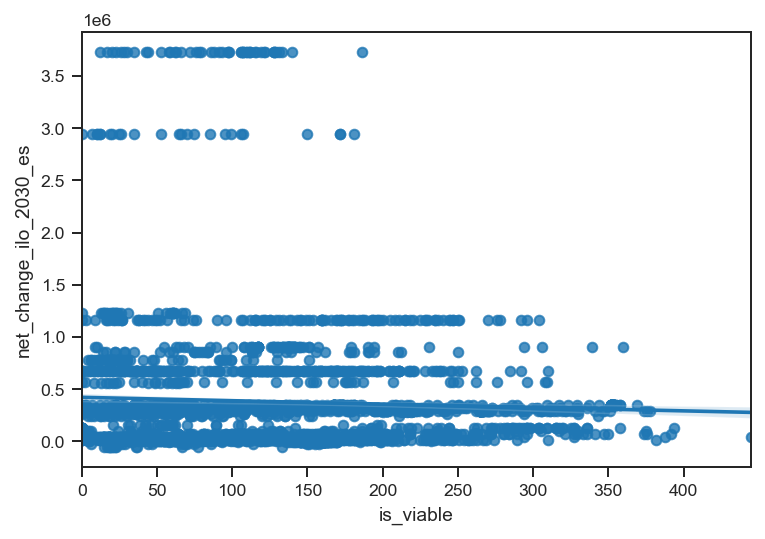

In [12]:
sns.regplot(
    data=df_metadata_transitions,
    x="is_viable",
    y="net_change_ilo_2030_es"
)

## Visualise transition numbers for all occupations

<ipython-input-13-94f1c8a63161>:23: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


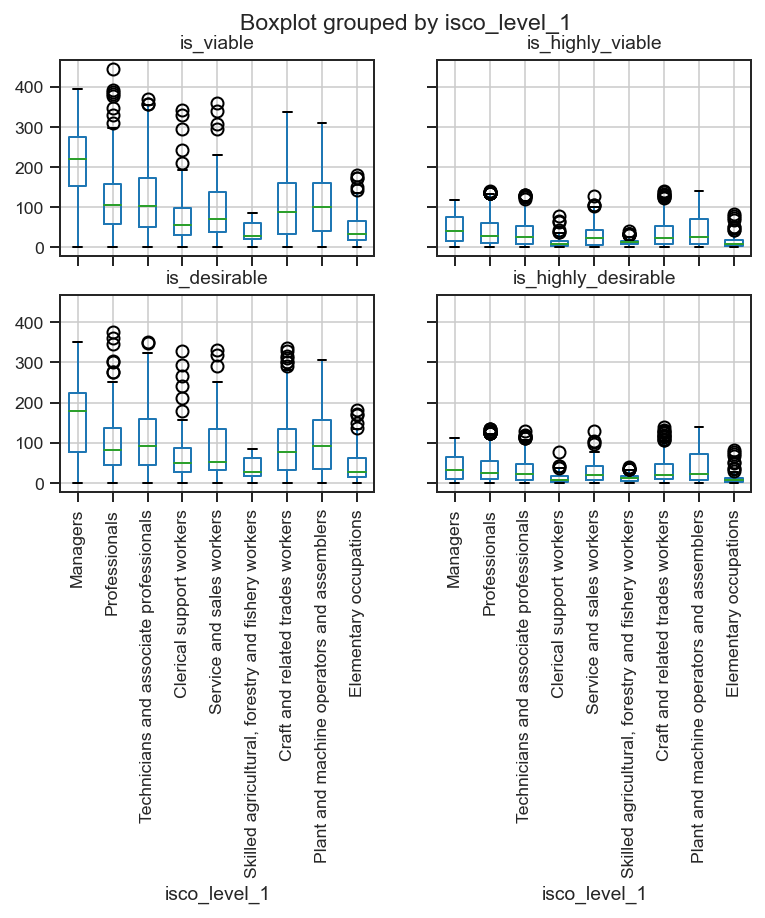

In [13]:
# boxplots of transition numbers by isco lvl 1 groups
isco_lvl1_mapping = {
    1: "Managers",
    2: "Professionals",
    3: "Technicians and associate professionals",
    4: "Clerical support workers",
    5: "Service and sales workers",
    6: "Skilled agricultural, forestry and fishery workers",
    7: "Craft and related trades workers",
    8: "Plant and machine operators and assemblers",
    9: "Elementary occupations"
}

df_transition_numbers_all_labelled.boxplot(
    column=["is_viable", "is_highly_viable", "is_desirable", "is_highly_desirable"],
    by="isco_level_1",
    layout=(2,2),
    rot=90
)

plt.xticks(np.arange(1,10), list(isco_lvl1_mapping.values()))

plt.tight_layout()

In [14]:
df_transition_numbers_all_labelled

,preferred_label,isco_level_1,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_viable_brown,is_viable_neutral,is_viable_green,is_highly_viable_brown,is_highly_viable_neutral,is_highly_viable_green,is_desirable_brown,is_desirable_neutral,is_desirable_green,is_highly_desirable_brown,is_highly_desirable_neutral,is_highly_desirable_green
0,technical director,2,29,3,21,1,0,27,2,0,3,0,0,19,2,0,1,0
1,metal drawing machine operator,8,175,128,175,128,96,66,13,75,49,4,96,66,13,75,49,4
2,precision device inspector,7,329,95,328,95,115,136,78,15,52,28,115,136,77,15,52,28
3,air traffic safety technician,3,82,13,75,13,2,61,19,0,13,0,2,57,16,0,13,0
4,hospitality revenue manager,2,296,28,232,25,3,206,87,0,16,12,3,145,84,0,15,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,demographer,2,134,40,122,36,3,84,47,1,27,12,3,75,44,1,26,9
2917,sorter labourer,9,12,2,11,2,2,6,4,0,0,2,1,6,4,0,0,2
2918,armoured car guard,5,53,16,50,15,1,50,2,0,16,0,1,47,2,0,15,0
2919,civil service administrative officer,2,81,3,56,3,0,72,9,0,3,0,0,47,9,0,3,0


In [15]:
# Visualise differences in transition options to neutral, green and mining
# occupations

value_vars = list(filter(None, [col_label if "is_" in col_label else None for col_label in df_transition_numbers_all_labelled.columns]))
df_ntrans_long = df_transition_numbers_all_labelled.melt(
    value_vars=value_vars,
    id_vars=['preferred_label', 'isco_level_1'],
    var_name="Target"
)

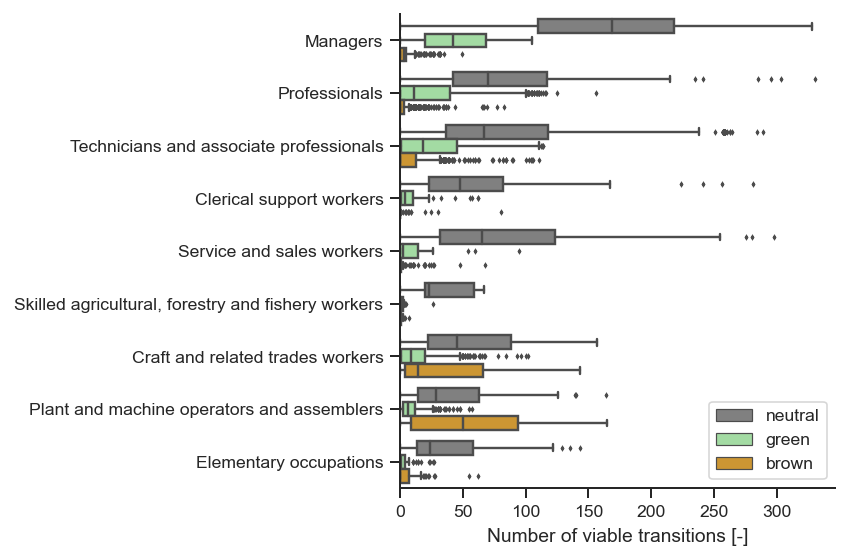

In [16]:
# viable
df_ntrans_long_is_viable = df_ntrans_long.query("Target == 'is_viable_brown' or Target == 'is_viable_neutral' or Target == 'is_viable_green'")
replace_dict = {"Target": {"is_viable_green": "green", "is_viable_neutral": "neutral", "is_viable_brown": "brown"}}

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="Target",
    hue_order=["neutral", "green", "brown"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_viable.replace(replace_dict)
)

ax.set_xlim(0)
plt.legend(loc="lower right")
#ax.set_title("Composition of viable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of viable transitions [-]")
ax.set_ylabel(None)
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()
sns.despine()

#### Experiment: try to normalise by counts of occupations per category

In [17]:
gbn_per_mg = df_metadata_transitions[["isco_level_1", "is_green", "is_brown", "is_neutral"]].groupby("isco_level_1").sum()
gbn_per_mg_long = gbn_per_mg.reset_index().melt(id_vars=["isco_level_1"], value_vars=["is_green", "is_brown", "is_neutral"], value_name="base_number")
gbn_per_mg_long = gbn_per_mg_long.replace({"variable": {"is_green": "green", "is_neutral": "neutral", "is_brown": "brown"}})

In [18]:
df_ntrans_long_is_viable_norm = pd.merge(
    df_ntrans_long_is_viable.replace(replace_dict),
    gbn_per_mg_long,
    left_on=["isco_level_1", "Target"],
    right_on=["isco_level_1", "variable"],
    how="left"
)

df_ntrans_long_is_viable_norm["quotient"] = df_ntrans_long_is_viable_norm["value"] / df_ntrans_long_is_viable_norm["base_number"]
df_ntrans_long_is_viable_norm

,preferred_label,isco_level_1,Target,value,variable,base_number,quotient
0,technical director,2,brown,0,brown,32,0.000000
1,metal drawing machine operator,8,brown,96,brown,219,0.438356
2,precision device inspector,7,brown,115,brown,77,1.493506
3,air traffic safety technician,3,brown,2,brown,56,0.035714
4,hospitality revenue manager,2,brown,3,brown,32,0.093750
...,...,...,...,...,...,...,...
8758,demographer,2,green,47,green,185,0.254054
8759,sorter labourer,9,green,4,green,4,1.000000
8760,armoured car guard,5,green,2,green,1,2.000000
8761,civil service administrative officer,2,green,9,green,185,0.048649


/Users/felix/Applications/miniconda3/envs/da/lib/python3.8/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/Users/felix/Applications/miniconda3/envs/da/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1183: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1


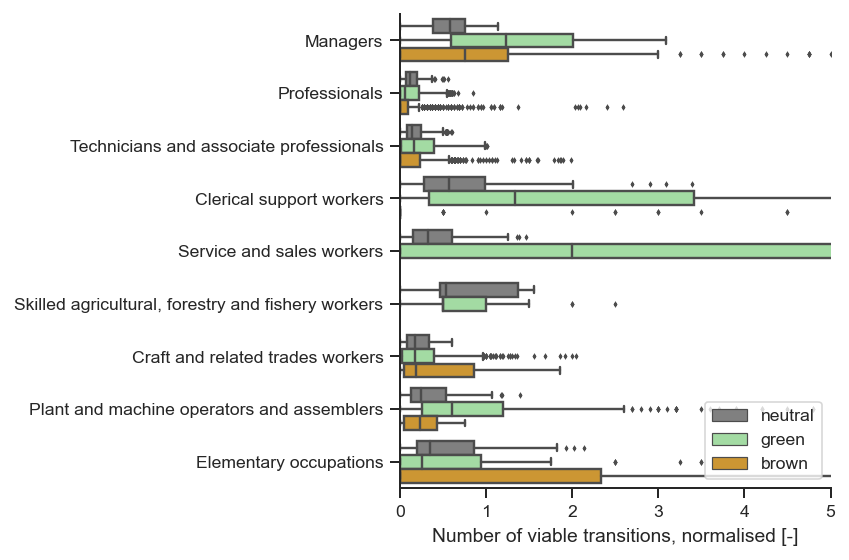

In [19]:
ax = sns.boxplot(
    y="isco_level_1",
    x="quotient",
    hue="Target",
    hue_order=["neutral", "green", "brown"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_viable_norm
)

ax.set_xlim(0, 5)
ax.set_xlim(0)
plt.legend(loc="lower right")
#ax.set_title("Composition of viable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of viable transitions, normalised [-]")
ax.set_ylabel(None)
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()
sns.despine()

#### Normal plots continue ...

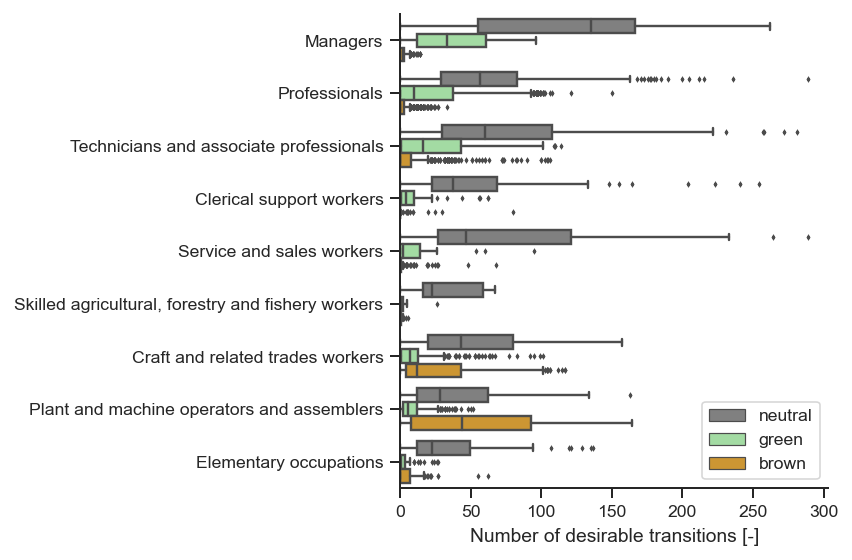

In [20]:
# desirable
df_ntrans_long_is_desirable = df_ntrans_long.query("Target == 'is_desirable_brown' or Target == 'is_desirable_neutral' or Target == 'is_desirable_green'")
replace_dict = {"Target": {"is_desirable_green": "green", "is_desirable_neutral": "neutral", "is_desirable_brown": "brown"}}

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="Target",
    hue_order=["neutral", "green", "brown"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_desirable.replace(replace_dict)
)

ax.set_xlim(0)
plt.legend(loc="lower right")
#ax.set_title("Composition of desirable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of desirable transitions [-]")
ax.set_ylabel(None)
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()
sns.despine()


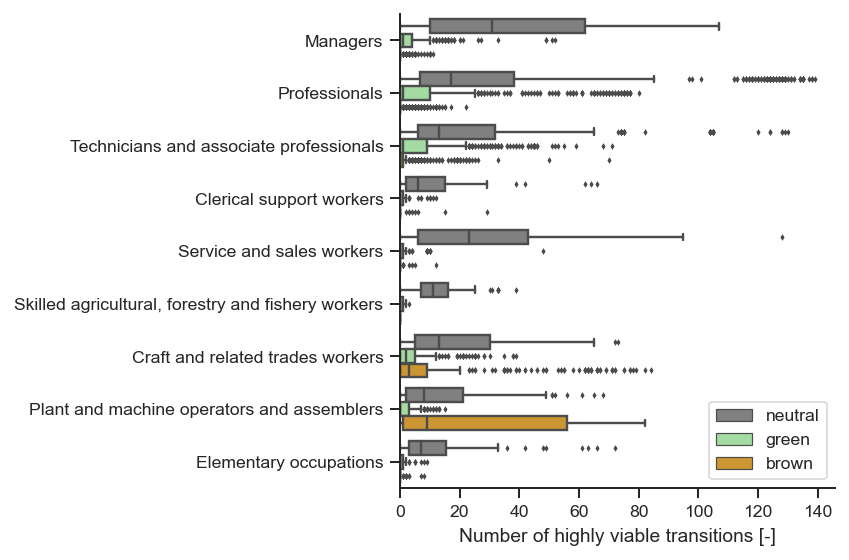

In [21]:
# highly viable
df_ntrans_long_is_highly_viable = df_ntrans_long.query("Target == 'is_highly_viable_brown' or Target == 'is_highly_viable_neutral' or Target == 'is_highly_viable_green'")
replace_dict = {"Target": {"is_highly_viable_green": "green", "is_highly_viable_neutral": "neutral", "is_highly_viable_brown": "brown"}}

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="Target",
    hue_order=["neutral", "green", "brown"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_highly_viable.replace(replace_dict)
)

ax.set_xlim(0)
plt.legend(loc="lower right")
#ax.set_title("Composition of highly viable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of highly viable transitions [-]")
ax.set_ylabel(None)
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()
sns.despine()

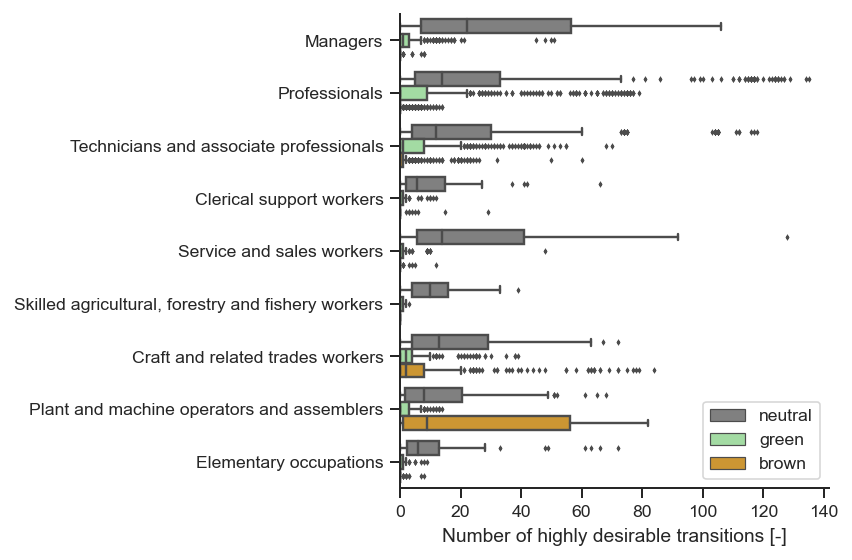

In [22]:
df_ntrans_long_is_highly_desirable = df_ntrans_long.query("Target == 'is_highly_desirable_brown' or Target == 'is_highly_desirable_neutral' or Target == 'is_highly_desirable_green'")
replace_dict = {"Target": {"is_highly_desirable_green": "green", "is_highly_desirable_neutral": "neutral", "is_highly_desirable_brown": "brown"}}

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="Target",
    hue_order=["neutral", "green", "brown"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_highly_desirable.replace(replace_dict)
)

ax.set_xlim(0)
plt.legend(loc="lower right")
#ax.set_title("Composition of highly desirable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of highly desirable transitions [-]")
ax.set_ylabel(None)
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()
sns.despine()

## Regression analysis of transition numbers

In [23]:
# to df
cols_merge = ["preferred_label", "isco_level_1", "annual_earnings", "education_level", "related_work_experience", "on_the_job_training", "job_zone", "is_green", "is_neutral"]
# df_transition_numbers_all = pd.DataFrame.from_dict(transition_numbers_all).transpose()
df_transition_numbers_all_labelled_wide = pd.concat(
    [df_transition_numbers_all, df_metadata[cols_merge]], axis=1
)

df_transition_numbers_all_labelled_wide

,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_viable_brown,is_viable_neutral,is_viable_green,is_highly_viable_brown,is_highly_viable_neutral,is_highly_viable_green,is_desirable_brown,is_desirable_neutral,is_desirable_green,is_highly_desirable_brown,is_highly_desirable_neutral,is_highly_desirable_green,preferred_label,isco_level_1,annual_earnings,education_level,related_work_experience,on_the_job_training,job_zone,is_green,is_neutral
0,29,3,21,1,0,27,2,0,3,0,0,19,2,0,1,0,technical director,2,37555.308176,6.2477,8.0309,4.3843,4.0,False,True
1,175,128,175,128,96,66,13,75,49,4,96,66,13,75,49,4,metal drawing machine operator,8,22031.963636,2.1163,2.4383,3.6486,2.0,False,False
2,329,95,328,95,115,136,78,15,52,28,115,136,77,15,52,28,precision device inspector,7,22430.367647,2.5397,4.8863,4.0288,2.0,True,False
3,82,13,75,13,2,61,19,0,13,0,2,57,16,0,13,0,air traffic safety technician,3,32754.000000,4.3848,5.4808,4.0782,3.0,False,True
4,296,28,232,25,3,206,87,0,16,12,3,145,84,0,15,10,hospitality revenue manager,2,38839.816377,6.8261,6.3481,3.8265,4.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,134,40,122,36,3,84,47,1,27,12,3,75,44,1,26,9,demographer,2,36135.290249,8.3000,5.5000,4.6000,5.0,False,True
2917,12,2,11,2,2,6,4,0,0,2,1,6,4,0,0,2,sorter labourer,9,21357.054545,3.1532,3.3559,2.8314,2.0,True,False
2918,53,16,50,15,1,50,2,0,16,0,1,47,2,0,15,0,armoured car guard,5,24315.540984,2.2215,3.2642,2.0230,2.0,False,True
2919,81,3,56,3,0,72,9,0,3,0,0,47,9,0,3,0,civil service administrative officer,2,33292.986333,3.9636,6.9711,3.4248,3.0,False,True


In [24]:
df_metadata_transitions

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce,is_brown,is_green,is_neutral,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_viable_brown,is_viable_neutral,is_viable_green,is_highly_viable_brown,is_highly_viable_neutral,is_highly_viable_green,is_desirable_brown,is_desirable_neutral,is_desirable_green,is_highly_desirable_brown,is_highly_desirable_neutral,is_highly_desirable_green
0,0,http://data.europa.eu/esco/occupation/00030d09...,technical director,2166,27-1011.00,art directors,2,21,216,Non Green,NaN,NaN,NaN,NaN,0.0000,36.670202,37555.308176,NaN,NaN,4.0,6.2477,8.0309,4.3843,H,500000.0,263000.0,-253000.0,-500000.0,10000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,True,29,3,21,1,0,27,2,0,3,0,0,19,2,0,1,0
1,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,51-4021.00,"extruding and drawing machine setters, operato...",8,81,812,Non Green,NaN,NaN,NaN,NaN,0.0000,39.904110,22031.963636,0.000020,645.0,2.0,2.1163,2.4383,3.6486,M,339000.0,712000.0,-34000.0,-339000.0,678000.0,2913000.0,500.0,-5589000.0,-2913000.0,-5588500.0,True,False,False,175,128,175,128,96,66,13,75,49,4,96,66,13,75,49,4
2,2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7543,51-9061.00,"inspectors, testers, sorters, samplers, and we...",7,75,754,Green Enhanced Skills,2.0,0.0,30.0,0.066667,0.0625,38.709386,22430.367647,NaN,NaN,2.0,2.5397,4.8863,4.0288,M,48000.0,316000.0,-500.0,-48000.0,315500.0,1315000.0,408000.0,-440000.0,-1315000.0,-32000.0,False,True,False,329,95,328,95,115,136,78,15,52,28,115,136,77,15,52,28
3,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,17-3023.01,electronics engineering technicians,3,31,315,Non Green,NaN,NaN,NaN,NaN,0.0000,42.036716,32754.000000,0.000087,2797.0,3.0,4.3848,5.4808,4.0782,H,748000.0,528000.0,-206000.0,-748000.0,322000.0,3042000.0,1225000.0,-965000.0,-3042000.0,260000.0,False,False,True,82,13,75,13,2,61,19,0,13,0,2,57,16,0,13,0
4,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,13-1161.00,market research analysts and marketing special...,2,24,243,Non Green,NaN,NaN,NaN,NaN,0.0000,36.354676,38839.816377,0.000648,20834.0,4.0,6.8261,6.3481,3.8265,H,218000.0,147000.0,-75000.0,-218000.0,72000.0,823000.0,837000.0,-53000.0,-823000.0,784000.0,False,False,True,296,28,232,25,3,206,87,0,16,12,3,145,84,0,15,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,15-2041.00,statisticians,2,21,212,Non Green,NaN,NaN,NaN,NaN,0.0000,35.494487,36135.290249,0.000286,9184.0,5.0,8.3000,5.5000,4.6000,H,500000.0,263000.0,-253000.0,-500000.0,10000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,True,134,40,122,36,3,84,47,1,27,12,3,75,44,1,26,9
2917,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,51-9199.01,recycling and reclamation workers,9,96,961,New Green N&E,18.0,0.0,0.0,1.000000,1.0000,39.443972,21357.054545,0.000417,13414.0,2.0,3.1532,3.3559,2.8314,L,153000.0,305000.0,-17000.0,-153000.0,288000.0,860000.0,1152000.0,-111000.0,-860000.0,1041000.0,False,True,False,12,2,11,2,2,6,4,0,0,2,1,6,4,0,0,2
29

In [25]:
from stargazer.stargazer import Stargazer

df_transition_numbers_all_labelled_wide["is_green_ratio"] = \
    df_transition_numbers_all_labelled_wide["is_viable_green"] / df_transition_numbers_all_labelled_wide["is_viable"]

reg_greenness = ols(
    formula="is_green_ratio ~ annual_earnings + education_level + related_work_experience + on_the_job_training + job_zone + C(isco_level_1)",
    data=df_transition_numbers_all_labelled_wide
).fit(cov_type='HC3')

Stargazer([reg_greenness])

In [26]:
reg_greenness = ols(
    formula="is_viable ~ annual_earnings + education_level + related_work_experience + on_the_job_training + C(job_zone) + C(isco_level_1) + is_green + is_neutral",
    data=df_transition_numbers_all_labelled_wide
).fit(cov_type='HC3')

Stargazer([reg_greenness])

#### How do the transition numbers vary between green, neutral and brown occupations?

In [27]:
# ["brown", "neutral", "green"]
df_metadata_transitions2 = df_metadata_transitions.copy()

df_metadata_transitions2["occ_type"] = df_metadata_transitions2[["is_brown", "is_neutral", "is_green"]].idxmax(axis=1)

In [28]:
df_metadata_transitions2_long = df_metadata_transitions2.melt(
    id_vars=["occ_type"],
    value_vars=["is_viable", "is_desirable", "is_highly_viable", "is_highly_desirable"],
    value_name="transitions",
    var_name="transition_category"
)

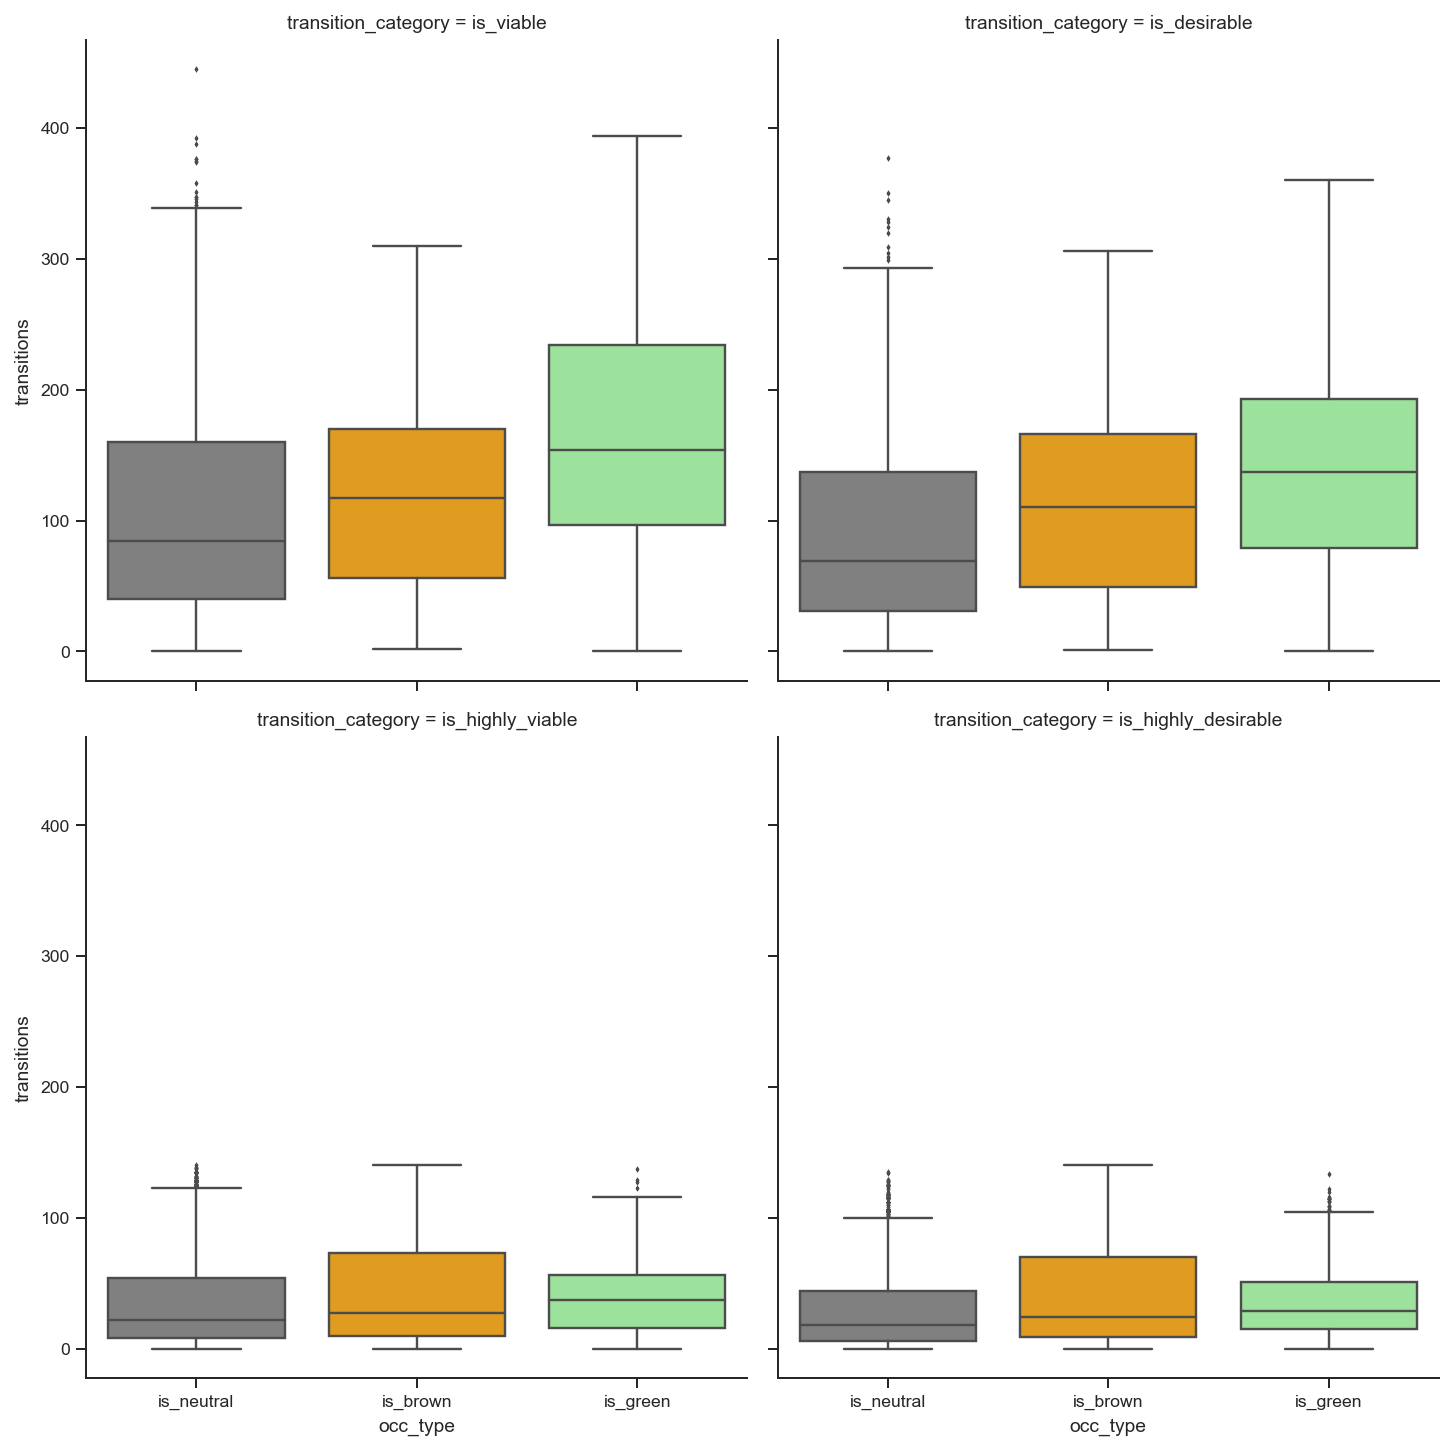

In [29]:
sns.catplot(
    y="transitions",
    x="occ_type",
    col="transition_category",
    col_wrap=2,
    palette=["grey", "orange", "lightgreen"],
    fliersize=1,
    kind="box",
    data=df_metadata_transitions2_long
)


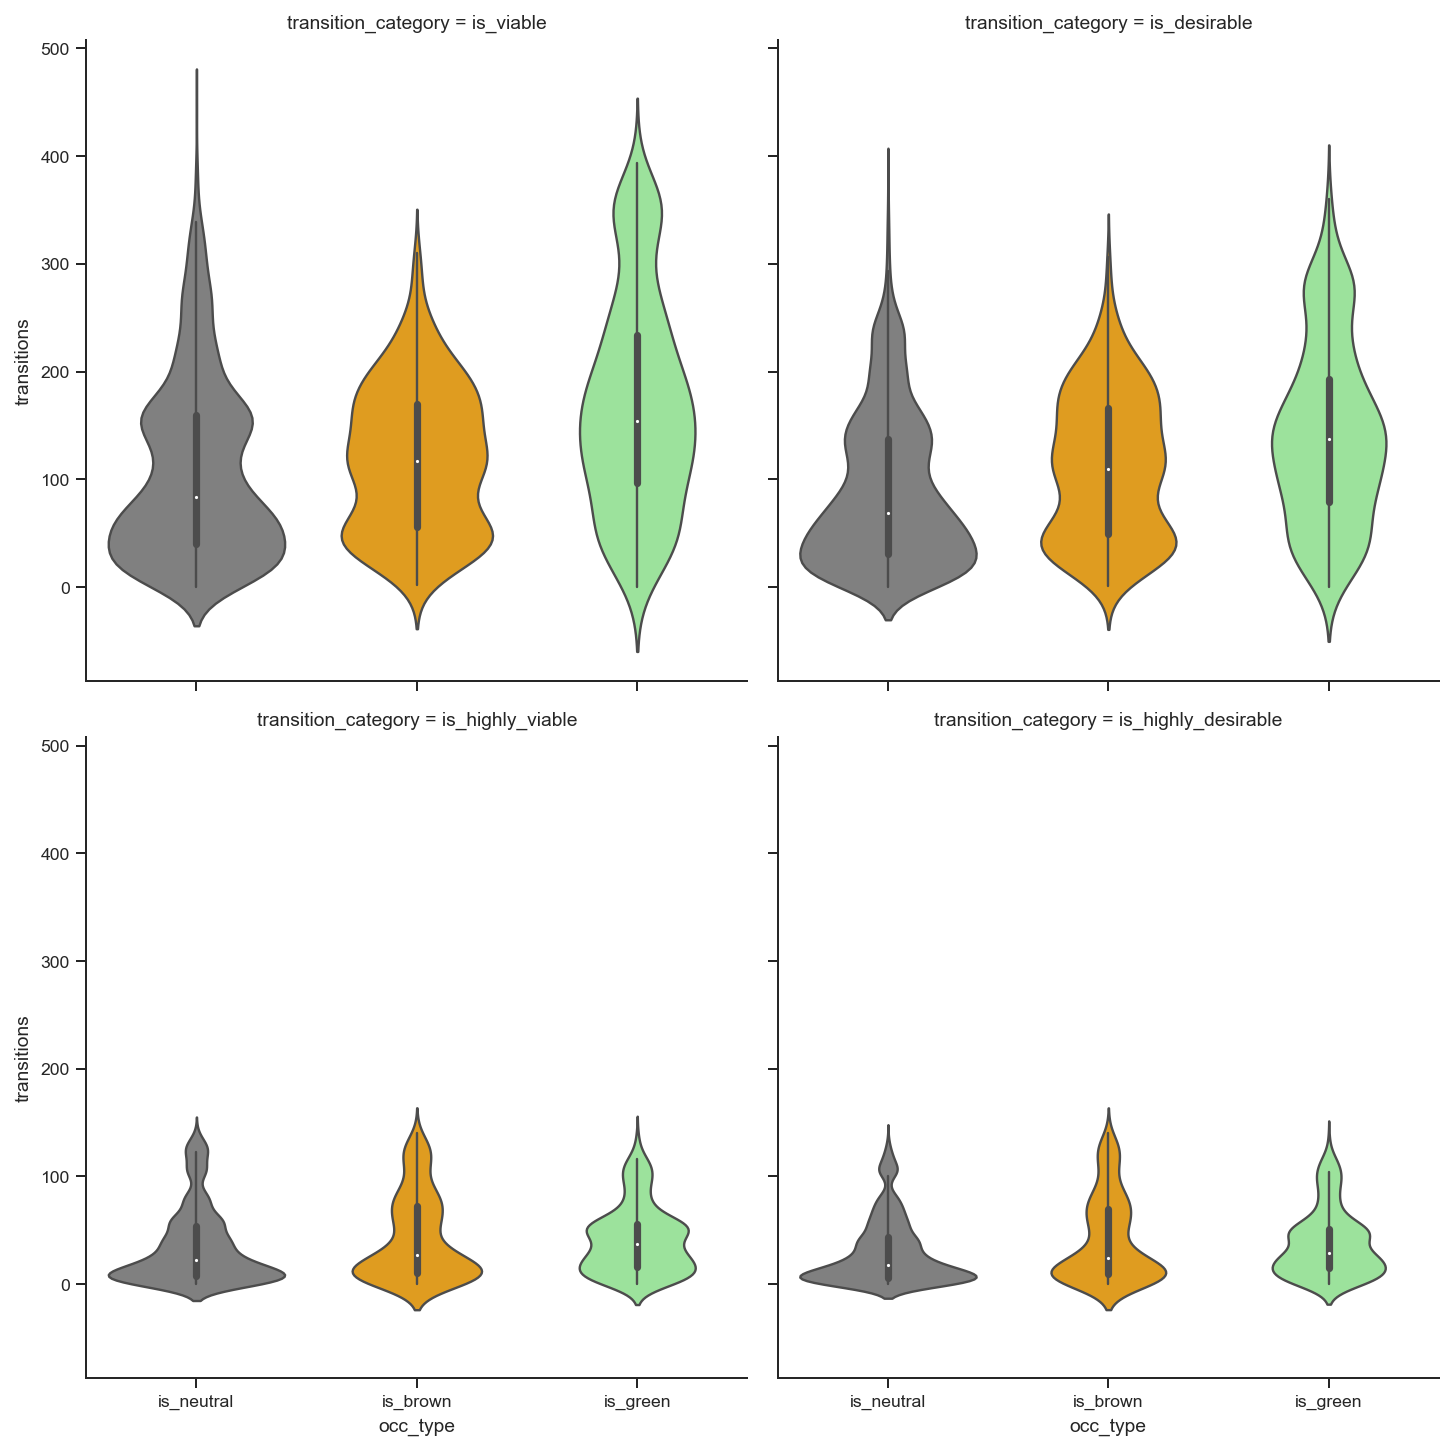

In [30]:
sns.catplot(
    y="transitions",
    x="occ_type",
    col="transition_category",
    col_wrap=2,
    palette=["grey", "orange", "lightgreen"],
    fliersize=1,
    kind="violin",
    data=df_metadata_transitions2_long
)

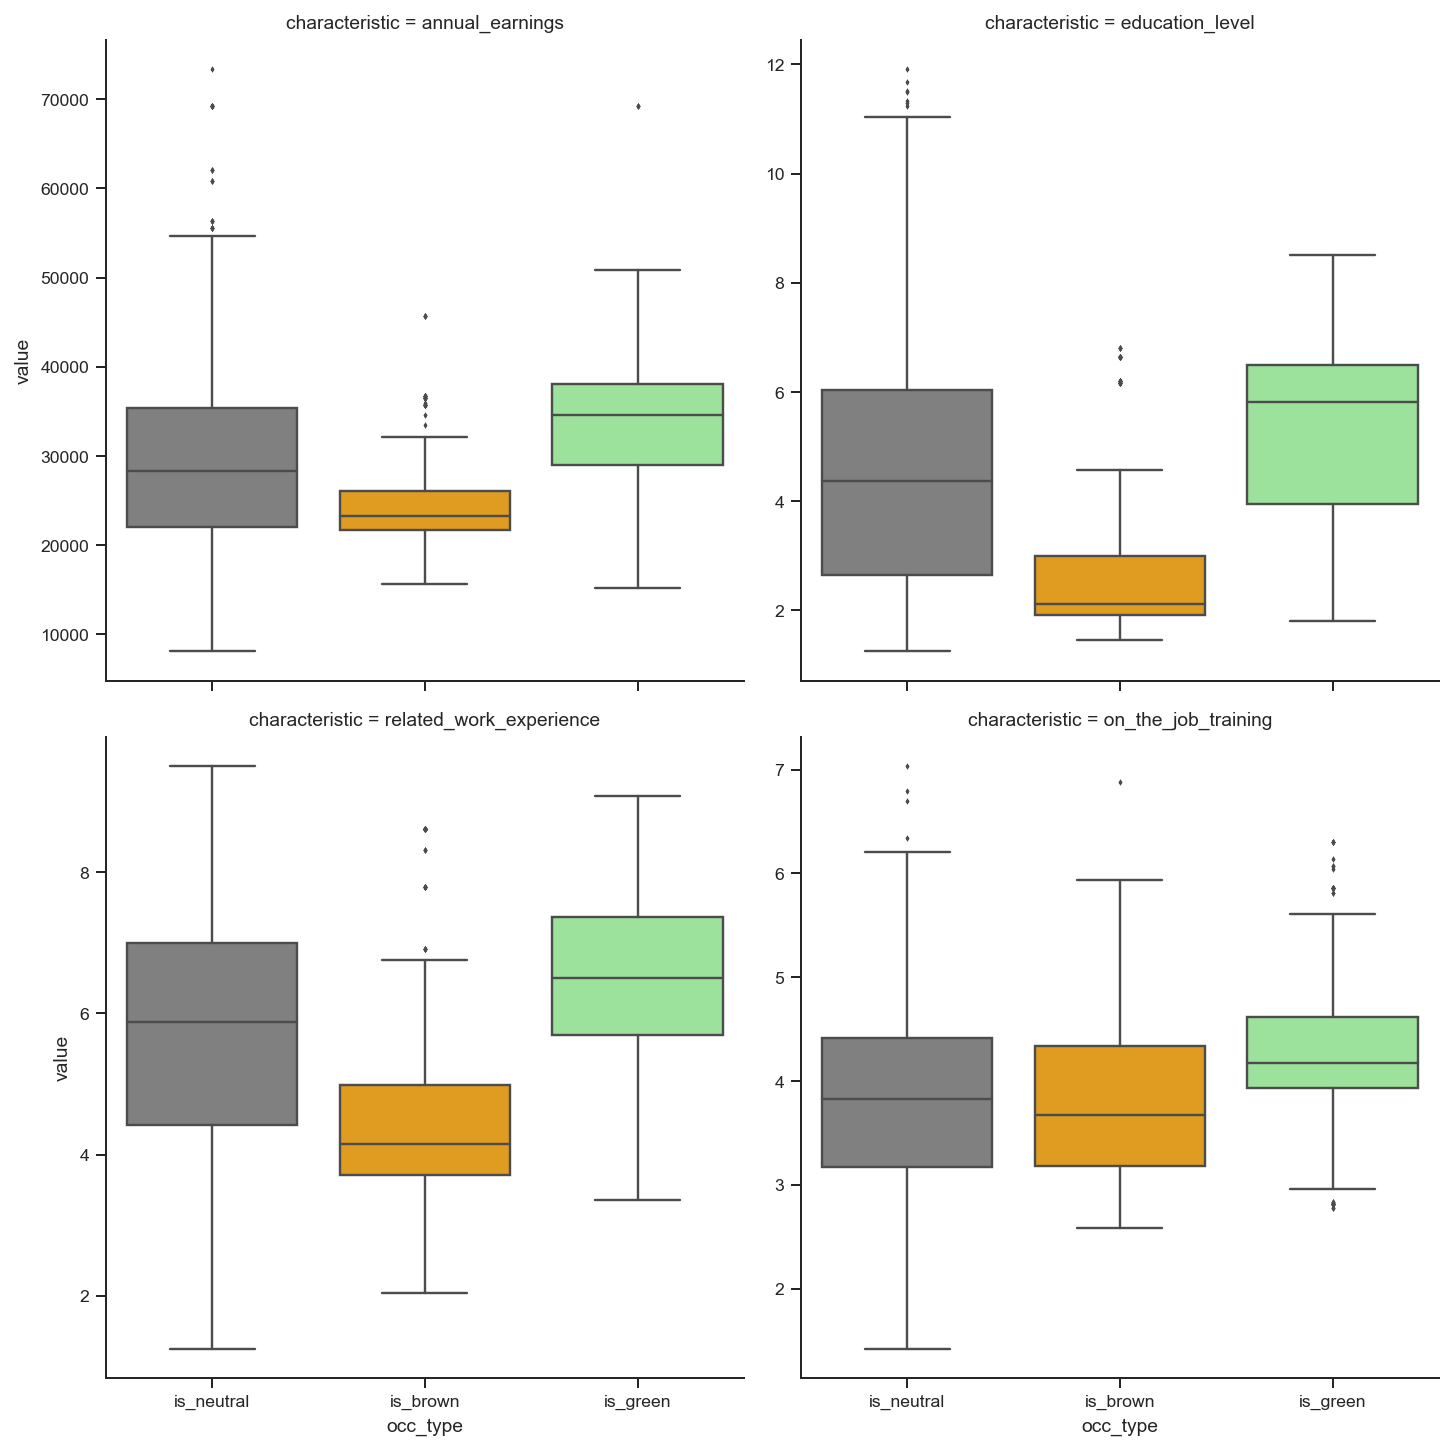

In [31]:
df_metadata_transitions3_long = df_metadata_transitions2.melt(
    id_vars=["occ_type"],
    value_vars=["annual_earnings", "education_level", "related_work_experience", "on_the_job_training"],
    value_name="value",
    var_name="characteristic"
)

sns.catplot(
    y="value",
    x="occ_type",
    col="characteristic",
    col_wrap=2,
    palette=["grey", "orange", "lightgreen"],
    fliersize=1,
    kind="box",
    sharey=False,
    data=df_metadata_transitions3_long
)

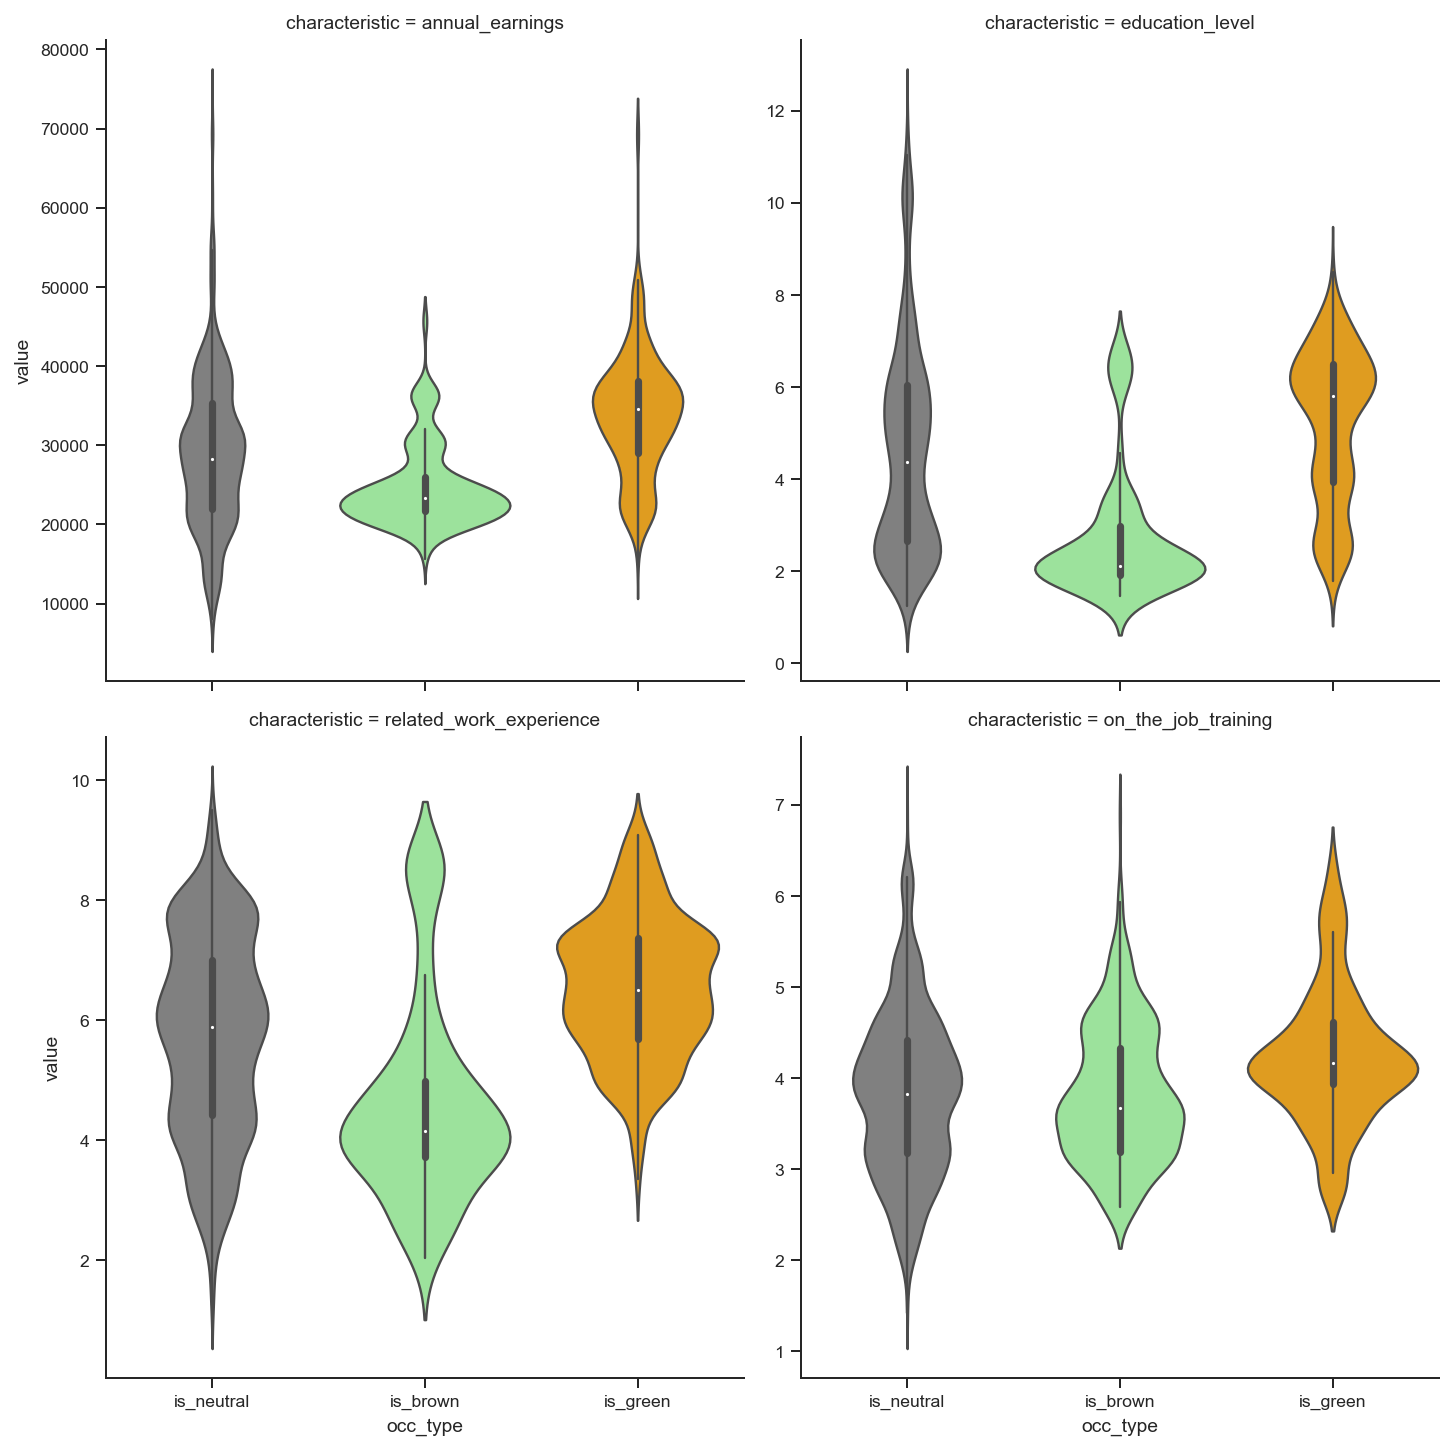

In [32]:
sns.catplot(
    y="value",
    x="occ_type",
    col="characteristic",
    col_wrap=2,
    palette=["grey", "lightgreen", "orange"],
    fliersize=1,
    kind="violin",
    sharey=False,
    data=df_metadata_transitions3_long
)

In [33]:
# t-tests for diff in means
from scipy import stats

stats.ttest_ind(
    df_metadata_transitions2.is_desirable_brown,
    df_metadata_transitions2.is_desirable_green
)

Ttest_indResult(statistic=-10.453089054851523, pvalue=2.371430211368237e-25)

In [34]:
stats.ttest_ind(
    df_metadata_transitions2.is_desirable_brown,
    df_metadata_transitions2.is_desirable_neutral
)

Ttest_indResult(statistic=-48.387147997384595, pvalue=0.0)

In [35]:
stats.ttest_ind(
    df_metadata_transitions2.is_desirable_green,
    df_metadata_transitions2.is_desirable_neutral
)

Ttest_indResult(statistic=-41.741702932604, pvalue=0.0)

#### Visualise boxplots in more granular way
- show transitions from all categories into all categories

In [36]:
# VIABLE
df_metadata_transitions2_long_v2 = df_metadata_transitions2.melt(
    id_vars=["occ_type"],
    value_vars=["is_viable_neutral", "is_viable_green", "is_viable_brown"],
    value_name="transitions",
    var_name="target"
)

replace_dict = {
    "target": {"is_viable_neutral": "neutral", "is_viable_green": "green", "is_viable_brown": "brown"},
    "occ_type": {"is_neutral": "neutral", "is_green": "green", "is_brown": "brown"}
}

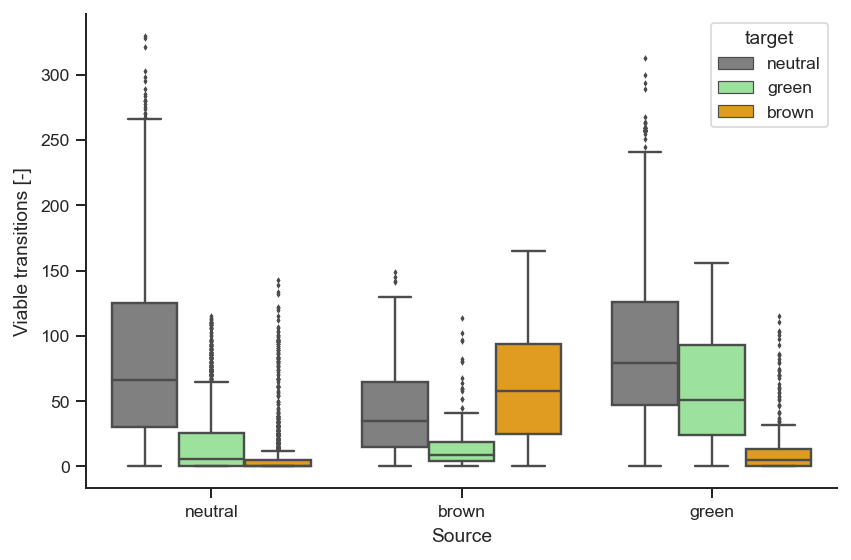

In [37]:
# boxplot
ax = sns.boxplot(
    x="occ_type",
    y="transitions",
    hue="target",
    palette=["grey", "lightgreen", "orange"],
    fliersize=1,
    data=df_metadata_transitions2_long_v2.replace(replace_dict)
)

ax.set_xlabel("Source")
ax.set_ylabel("Viable transitions [-]")
sns.despine()
plt.tight_layout()

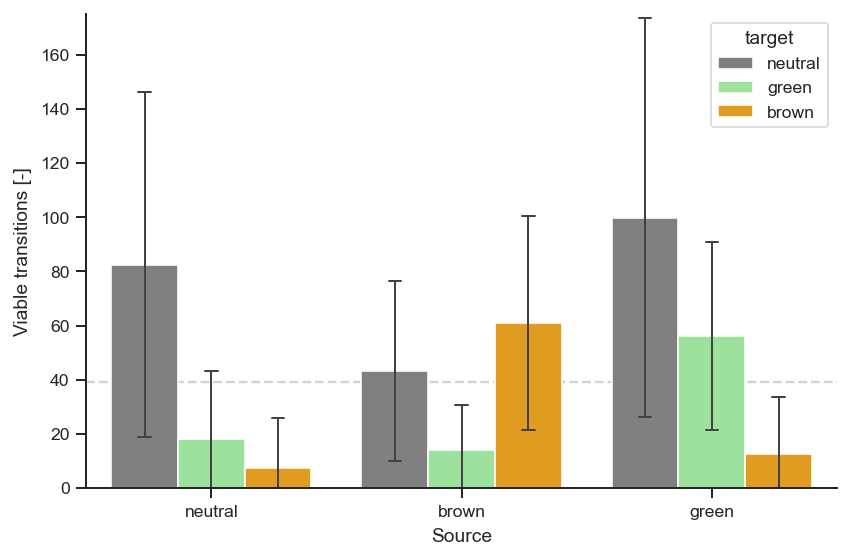

In [38]:
# barplot
ax = sns.barplot(
    x="occ_type",
    y="transitions",
    hue="target",
    palette=["grey", "lightgreen", "orange"],
    ci="sd",
    capsize=0.05,
    errwidth=1,
    data=df_metadata_transitions2_long_v2.replace(replace_dict)
)

ax.axhline(
    df_metadata_transitions2["is_viable"].mean() / 3,
    linestyle="--",
    color="lightgrey",
    zorder=0
)

ax.set_ylim(0, 175)
ax.set_xlabel("Source")
ax.set_ylabel("Viable transitions [-]")
sns.despine()
plt.tight_layout()

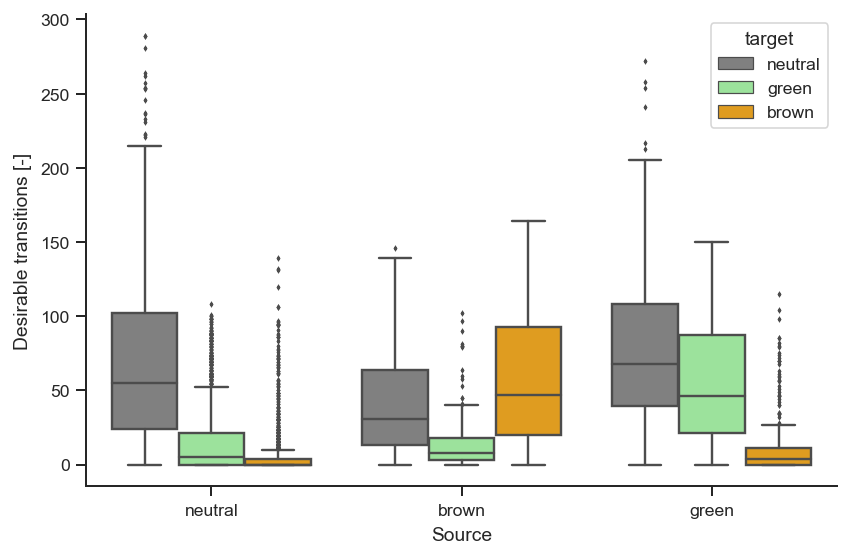

In [39]:
# DESIRABLE
df_metadata_transitions2_long_v2 = df_metadata_transitions2.melt(
    id_vars=["occ_type"],
    value_vars=["is_desirable_neutral", "is_desirable_green", "is_desirable_brown"],
    value_name="transitions",
    var_name="target"
)

replace_dict = {
    "target": {"is_desirable_neutral": "neutral", "is_desirable_green": "green", "is_desirable_brown": "brown"},
    "occ_type": {"is_neutral": "neutral", "is_green": "green", "is_brown": "brown"}
}

# boxplot
ax = sns.boxplot(
    x="occ_type",
    y="transitions",
    hue="target",
    palette=["grey", "lightgreen", "orange"],
    fliersize=1,
    data=df_metadata_transitions2_long_v2.replace(replace_dict)
)

ax.set_xlabel("Source")
ax.set_ylabel("Desirable transitions [-]")
sns.despine()
plt.tight_layout()

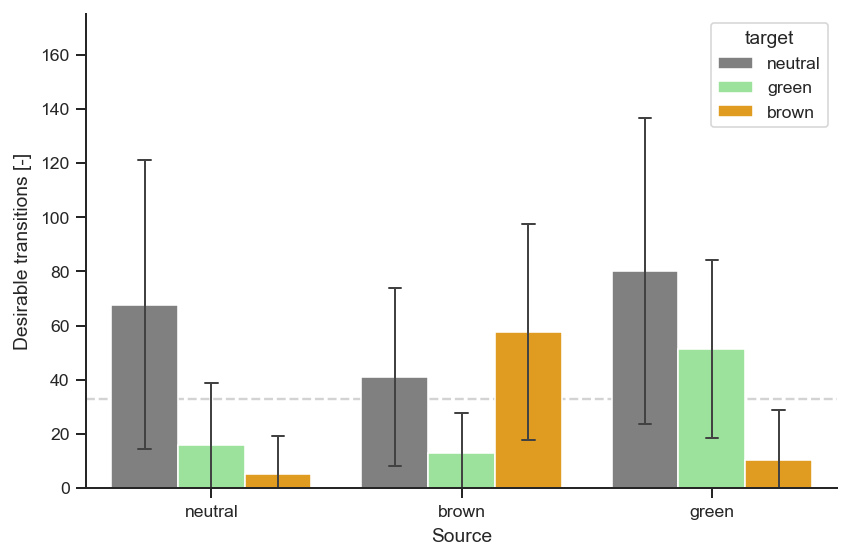

In [40]:
# barplot
ax = sns.barplot(
    x="occ_type",
    y="transitions",
    hue="target",
    palette=["grey", "lightgreen", "orange"],
    ci="sd",
    capsize=0.05,
    errwidth=1,
    data=df_metadata_transitions2_long_v2.replace(replace_dict)
)

ax.axhline(
    df_metadata_transitions2["is_desirable"].mean() / 3,
    linestyle="--",
    color="lightgrey",
    zorder=0
)

ax.set_ylim(0, 175)
ax.set_xlabel("Source")
ax.set_ylabel("Desirable transitions [-]")
sns.despine()
plt.tight_layout()

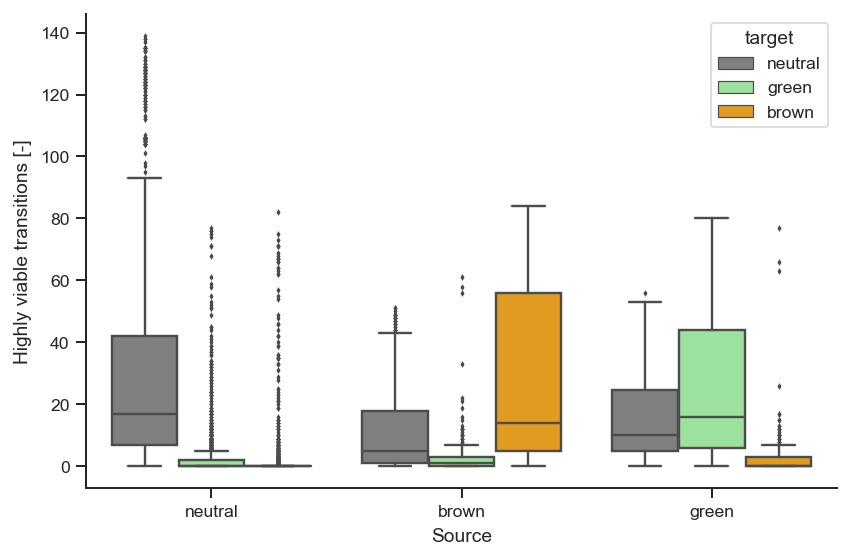

In [41]:
# HIGHLY VIABLE
df_metadata_transitions2_long_v2 = df_metadata_transitions2.melt(
    id_vars=["occ_type"],
    value_vars=["is_highly_viable_neutral", "is_highly_viable_green", "is_highly_viable_brown"],
    value_name="transitions",
    var_name="target"
)

replace_dict = {
    "target": {"is_highly_viable_neutral": "neutral", "is_highly_viable_green": "green", "is_highly_viable_brown": "brown"},
    "occ_type": {"is_neutral": "neutral", "is_green": "green", "is_brown": "brown"}
}

# boxplot
ax = sns.boxplot(
    x="occ_type",
    y="transitions",
    hue="target",
    palette=["grey", "lightgreen", "orange"],
    fliersize=1,
    data=df_metadata_transitions2_long_v2.replace(replace_dict)
)

ax.set_xlabel("Source")
ax.set_ylabel("Highly viable transitions [-]")
sns.despine()
plt.tight_layout()

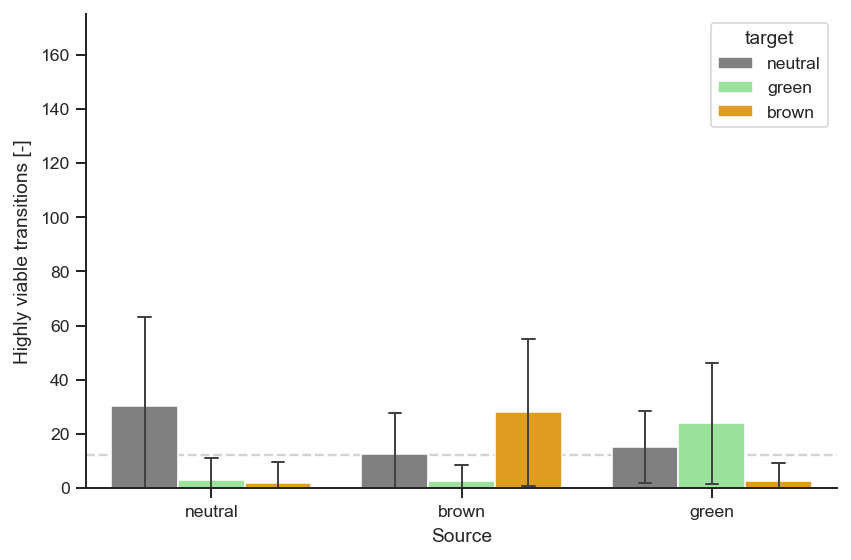

In [42]:
# barplot
ax = sns.barplot(
    x="occ_type",
    y="transitions",
    hue="target",
    palette=["grey", "lightgreen", "orange"],
    ci="sd",
    capsize=0.05,
    errwidth=1,
    data=df_metadata_transitions2_long_v2.replace(replace_dict)
)

ax.axhline(
    df_metadata_transitions2["is_highly_viable"].mean() / 3,
    linestyle="--",
    color="lightgrey",
    zorder=0
)

ax.set_ylim(0, 175)
ax.set_xlabel("Source")
ax.set_ylabel("Highly viable transitions [-]")
sns.despine()
plt.tight_layout()


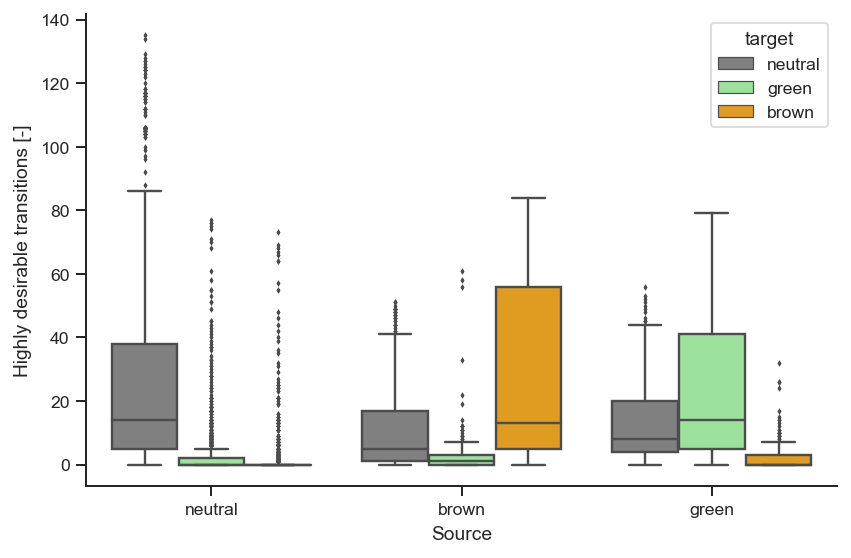

In [43]:
# HIGHLY DESIRABLE
df_metadata_transitions2_long_v2 = df_metadata_transitions2.melt(
    id_vars=["occ_type"],
    value_vars=["is_highly_desirable_neutral", "is_highly_desirable_green", "is_highly_desirable_brown"],
    value_name="transitions",
    var_name="target"
)

replace_dict = {
    "target": {"is_highly_desirable_neutral": "neutral", "is_highly_desirable_green": "green", "is_highly_desirable_brown": "brown"},
    "occ_type": {"is_neutral": "neutral", "is_green": "green", "is_brown": "brown"}
}

# boxplot
ax = sns.boxplot(
    x="occ_type",
    y="transitions",
    hue="target",
    palette=["grey", "lightgreen", "orange"],
    fliersize=1,
    data=df_metadata_transitions2_long_v2.replace(replace_dict)
)

ax.set_xlabel("Source")
ax.set_ylabel("Highly desirable transitions [-]")
sns.despine()
plt.tight_layout()

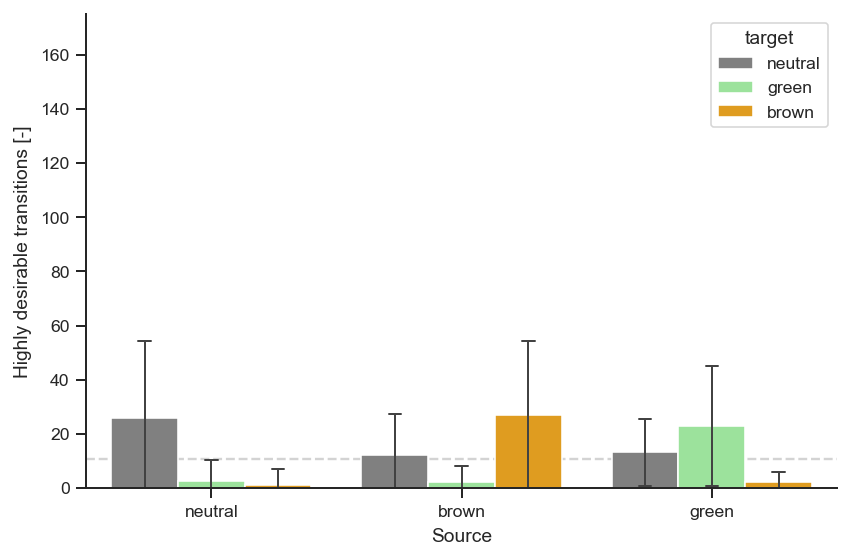

In [44]:
# barplot
ax = sns.barplot(
    x="occ_type",
    y="transitions",
    hue="target",
    palette=["grey", "lightgreen", "orange"],
    ci="sd",
    capsize=0.05,
    errwidth=1,
    data=df_metadata_transitions2_long_v2.replace(replace_dict)
)

ax.axhline(
    df_metadata_transitions2["is_highly_desirable"].mean() / 3,
    linestyle="--",
    color="lightgrey",
    zorder=0
)

ax.set_ylim(0, 175)
ax.set_xlabel("Source")
ax.set_ylabel("Highly desirable transitions [-]")
sns.despine()
plt.tight_layout()

#### Let's concentrate on the actual research question: the transition possibilities of brown occupations

- don't cover transitions out of neutral or green occupations
- focus exclusively on transitions out of brown occupations and look at it more granularly

In [45]:
# store mean values of transition numbers per category
transition_cats = ["is_viable", "is_desirable", "is_highly_viable", "is_highly_desirable"]

transition_cat_means = {}
transition_cat_medians = {}

for cat in transition_cats:
    transition_cat_means[cat] = df_metadata_transitions2[cat].mean()
    transition_cat_medians[cat] = df_metadata_transitions2[cat].median()

In [46]:
df_metadata_transitions2_brown = df_metadata_transitions2.query("occ_type == 'is_brown'")

In [47]:
list_of_value_vars = [
    ["is_viable_brown", "is_viable_neutral", "is_viable_green"],
    ["is_highly_viable_brown", "is_highly_viable_neutral", "is_highly_viable_green"],
    ["is_desirable_brown", "is_desirable_neutral", "is_desirable_green"],
    ["is_highly_desirable_brown", "is_highly_desirable_neutral", "is_highly_desirable_green"],
]

list_of_df_categories = []

for i, value_vars in enumerate(list_of_value_vars):
    df_categories = df_metadata_transitions2_brown.melt(
        value_vars=value_vars,
        value_name="transitions",
        var_name="target",
        id_vars="isco_level_1"
    )

    ids = pd.DataFrame(np.column_stack(list(zip(*df_categories.target.str.split("_")))))

    if (i % 2) == 0:
        df_categories["category"] = ids.iloc[:, 1]
        df_categories["target"] = ids.iloc[:, 2]
    else:
        df_categories["category"] = ids.iloc[:, 1] + "_" + ids.iloc[:, 2]
        df_categories["target"] = ids.iloc[:, 3]

    list_of_df_categories.append(df_categories)

df_categories_long = pd.concat(list_of_df_categories).reset_index(drop=True)
df_categories_long["category"] = pd.Categorical(df_categories_long["category"], ["viable", "desirable", "highly_viable", "highly_desirable"])

In [48]:
# subset by isco code
df_categories_long.groupby(["isco_level_1", "category", "target"]).mean()

transitions
isco_level_1 category         target              
1            viable           brown      23.250000
                              green      31.250000
                              neutral    71.000000
             desirable        brown      13.250000
                              green      21.750000
                              neutral    49.500000
             highly_viable    brown      10.000000
                              green       3.250000
                              neutral     2.250000
             highly_desirable brown       7.750000
                              green       3.250000
                              neutral     1.000000
2            viable           brown      25.000000
                              green      35.656250
                              neutral    32.625000
             desirable        brown      15.406250
                              green      30.156250
                              neutral    27.437500
             highly_viable    brown       6.843750
                              green       9.656250
                              neutral     4.500000
             highly_desirable brown       5.625000
                              green       9.250000
                              neutral     3.406250
3            viable           brown      42.357143
                              green      21.964286
                              neutral    61.107143
             desirable        brown      40.910714
                              green      21.678571
                              neutral    58.821429
             highly_viable    brown      14.053571
                              green       2.571429
                              neutral     9.517857
             highly_desirable brown      13.714286
                              green       2.517857
                              neutral     9.089286
4            viable           brown      17.000000
                              green      20.500000
                              neutral    24.000000
             desirable        brown      17.000000
                              green      20.500000
                              neutral    24.000000
             highly_viable    brown       4.500000
                              green       4.500000
                              neutral     3.000000
             highly_desirable brown       4.500000
                              green       4.500000
                              neutral     3.000000
7            viable           brown      53.857143
                              green      13.779221
                              neutral    52.610390
             desirable        brown      47.454545
                              green      10.454545
                              neutral    49.753247
             highly_viable    brown      23.285714
                              green       3.181818
                              neutral    17.025974
             highly_desirable brown      21.038961
                              green       2.363636
                              neutral    16.558442
8            viable           brown      74.958904
                              green       8.817352
                              neutral    36.876712
             desirable        brown      73.479452
                              green       8.744292
                              neutral    35.520548
             highly_viable    brown      37.013699
                              green       1.205479
                              neutral    13.388128
             highly_desirable brown      36.621005
                              green       1.178082
                              neutral    13.127854
9            viable           brown      18.333333
                              green       8.666667
                              neutral    27.000000
             desirable        brown      18.000000
                              green       8.666667
          

In [49]:
transition_cat_means_num = {
    'is_viable': 100.90345771995892,
    'is_desirable': 87.37247517973297,
    'is_highly_viable': 32.82505991098939,
    'is_highly_desirable': 29.31941116056145
}

delta_mean = df_categories_long.groupby(["category", "target"]).mean().reset_index().set_index("category").join(
    pd.DataFrame(transition_cat_means_num, index=["category"]).T,
    how="left",
)

delta_mean["delta"] = delta_mean.transitions - delta_mean.category / 3
delta_mean["ratio"] = (delta_mean.transitions / (delta_mean.category / 3)) - 1
delta_mean.round(2)

,target,isco_level_1,transitions,category,delta,ratio
desirable,brown,6.52,57.69,NaN,NaN,NaN
desirable,green,6.52,12.86,NaN,NaN,NaN
desirable,neutral,6.52,40.99,NaN,NaN,NaN
highly_desirable,brown,6.52,27.07,NaN,NaN,NaN
highly_desirable,green,6.52,2.30,NaN,NaN,NaN
highly_desirable,neutral,6.52,12.17,NaN,NaN,NaN
highly_viable,brown,6.52,27.90,NaN,NaN,NaN
highly_viable,green,6.52,2.51,NaN,NaN,NaN
highly_viable,neutral,6.52,12.57,NaN,NaN,NaN
viable,brown,6.52,60.86,NaN,NaN,NaN


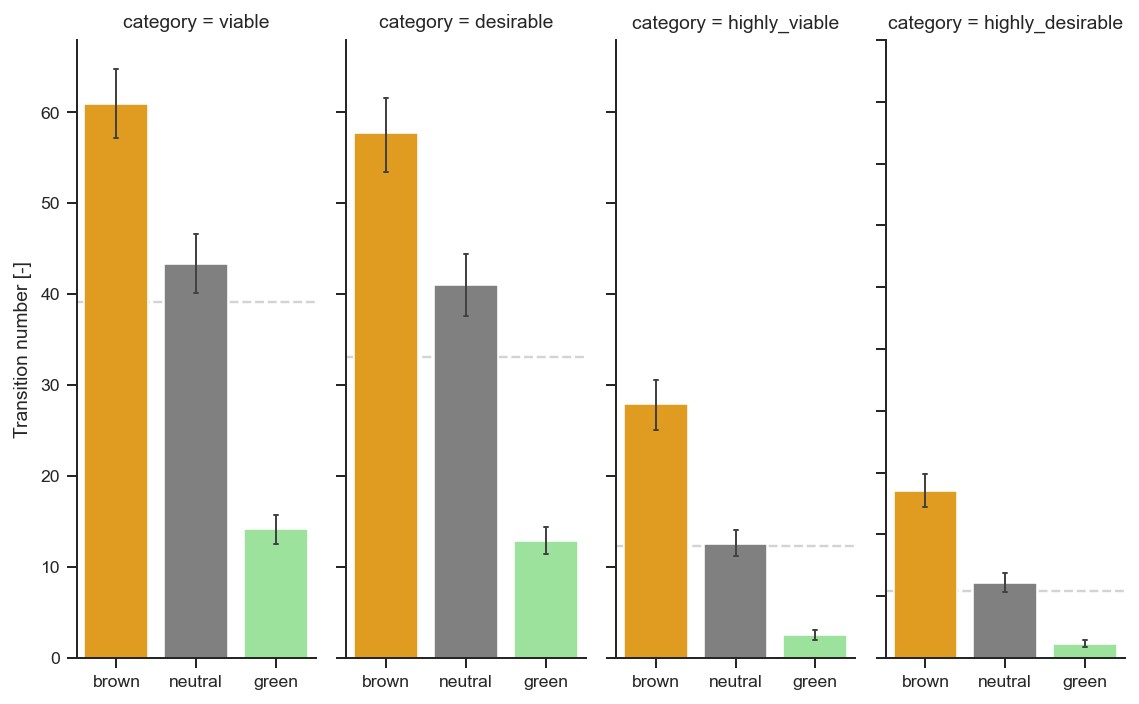

In [50]:
c = sns.catplot(
    y="transitions",
    x="target",
    col="category",
    #col_wrap=2,
    kind="bar",
    order=["brown", "neutral", "green"],
    palette=["orange", "grey", "lightgreen"],
    ci=95,
    capsize=0.05,
    errwidth=1,
    sharex=False,
    height=5,
    aspect=0.4,
    data=df_categories_long
)

for cat, ax in zip(transition_cats, c.axes[0]):
    ax.set_ylim(0)
    ax.set_xlabel(None)
    ax.set_yticks(np.arange(0, 110, 10))

    ax.axhline(
    transition_cat_means[cat] / 3,
    linestyle="--",
    color="lightgrey",
    zorder=0
)

c.axes[0][0].set_ylabel("Transition number [-]")

plt.tight_layout()


#plt.savefig(
#    os.path.join(figure_dir, "RQ4", "n_transitions_source_brown_only_barplot.png"),
#    dpi=300,
#    bbox_inches="tight"
#)

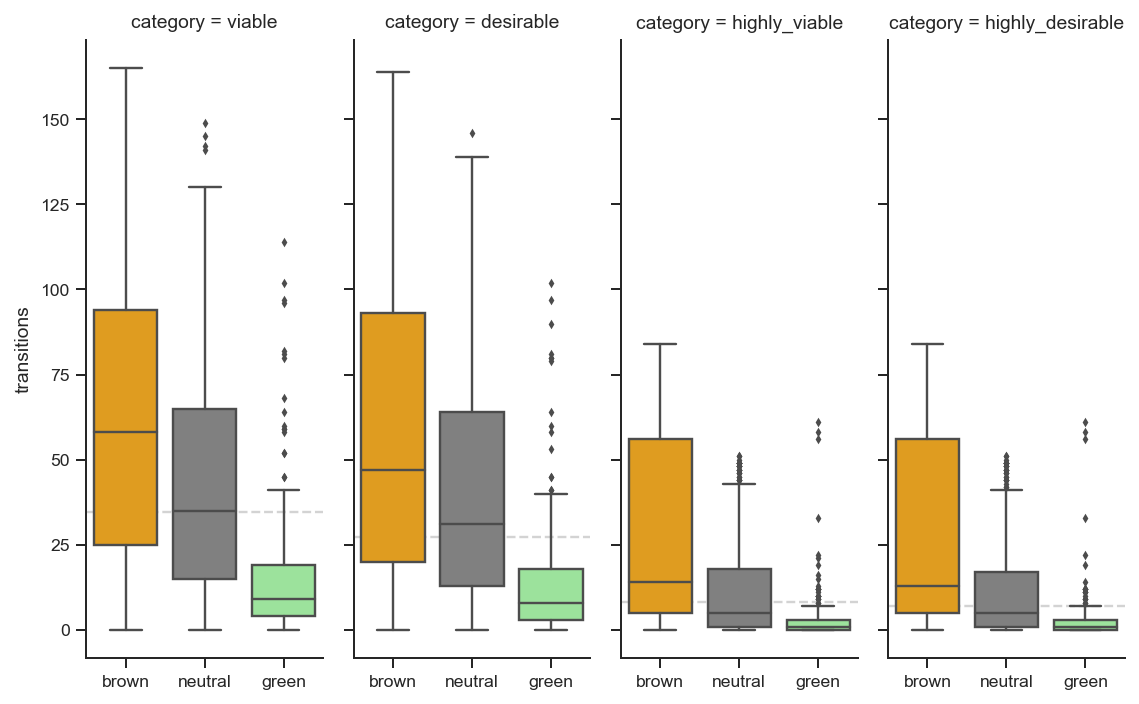

In [66]:
c = sns.catplot(
    y="transitions",
    x="target",
    col="category",
    #col_wrap=1,
    kind="box",
    order=["brown", "neutral", "green"],
    palette=["orange", "grey", "lightgreen"],
    sharex=False,
    height=5,
    aspect=0.4,
    fliersize=2,
    data=df_categories_long
)

for cat, ax in zip(transition_cats, c.axes[0]):
    #ax.set_ylim(0)
    ax.set_xlabel(None)

    ax.axhline(
    transition_cat_medians[cat] / 3,
    linestyle="--",
    color="lightgrey",
    zorder=0
)

plt.tight_layout()

#plt.savefig(
#    os.path.join(figure_dir, "RQ4", "n_transitions_source_brown_only_boxplot.png"),
#    dpi=300,
#    bbox_inches="tight"
#)

In [52]:
df_categories_long.groupby(["category", "target"]).mean()

isco_level_1  transitions
category         target                            
viable           brown        6.519084    60.857506
                 green        6.519084    14.134860
                 neutral      6.519084    43.272265
desirable        brown        6.519084    57.687023
                 green        6.519084    12.857506
                 neutral      6.519084    40.987277
highly_viable    brown        6.519084    27.895674
                 green        6.519084     2.511450
                 neutral      6.519084    12.569975
highly_desirable brown        6.519084    27.066158
                 green        6.519084     2.295165
                 neutral      6.519084    12.170483

#### group barplots by isco-08 1-digit level

In [53]:
new_labels = []
for entry in list(isco_lvl1_mapping.items()):
    code, label = entry
    new_label = str(code) + ": " + label
    new_labels.append(new_label)

new_labels_short = new_labels[0:4] + new_labels[6:9]

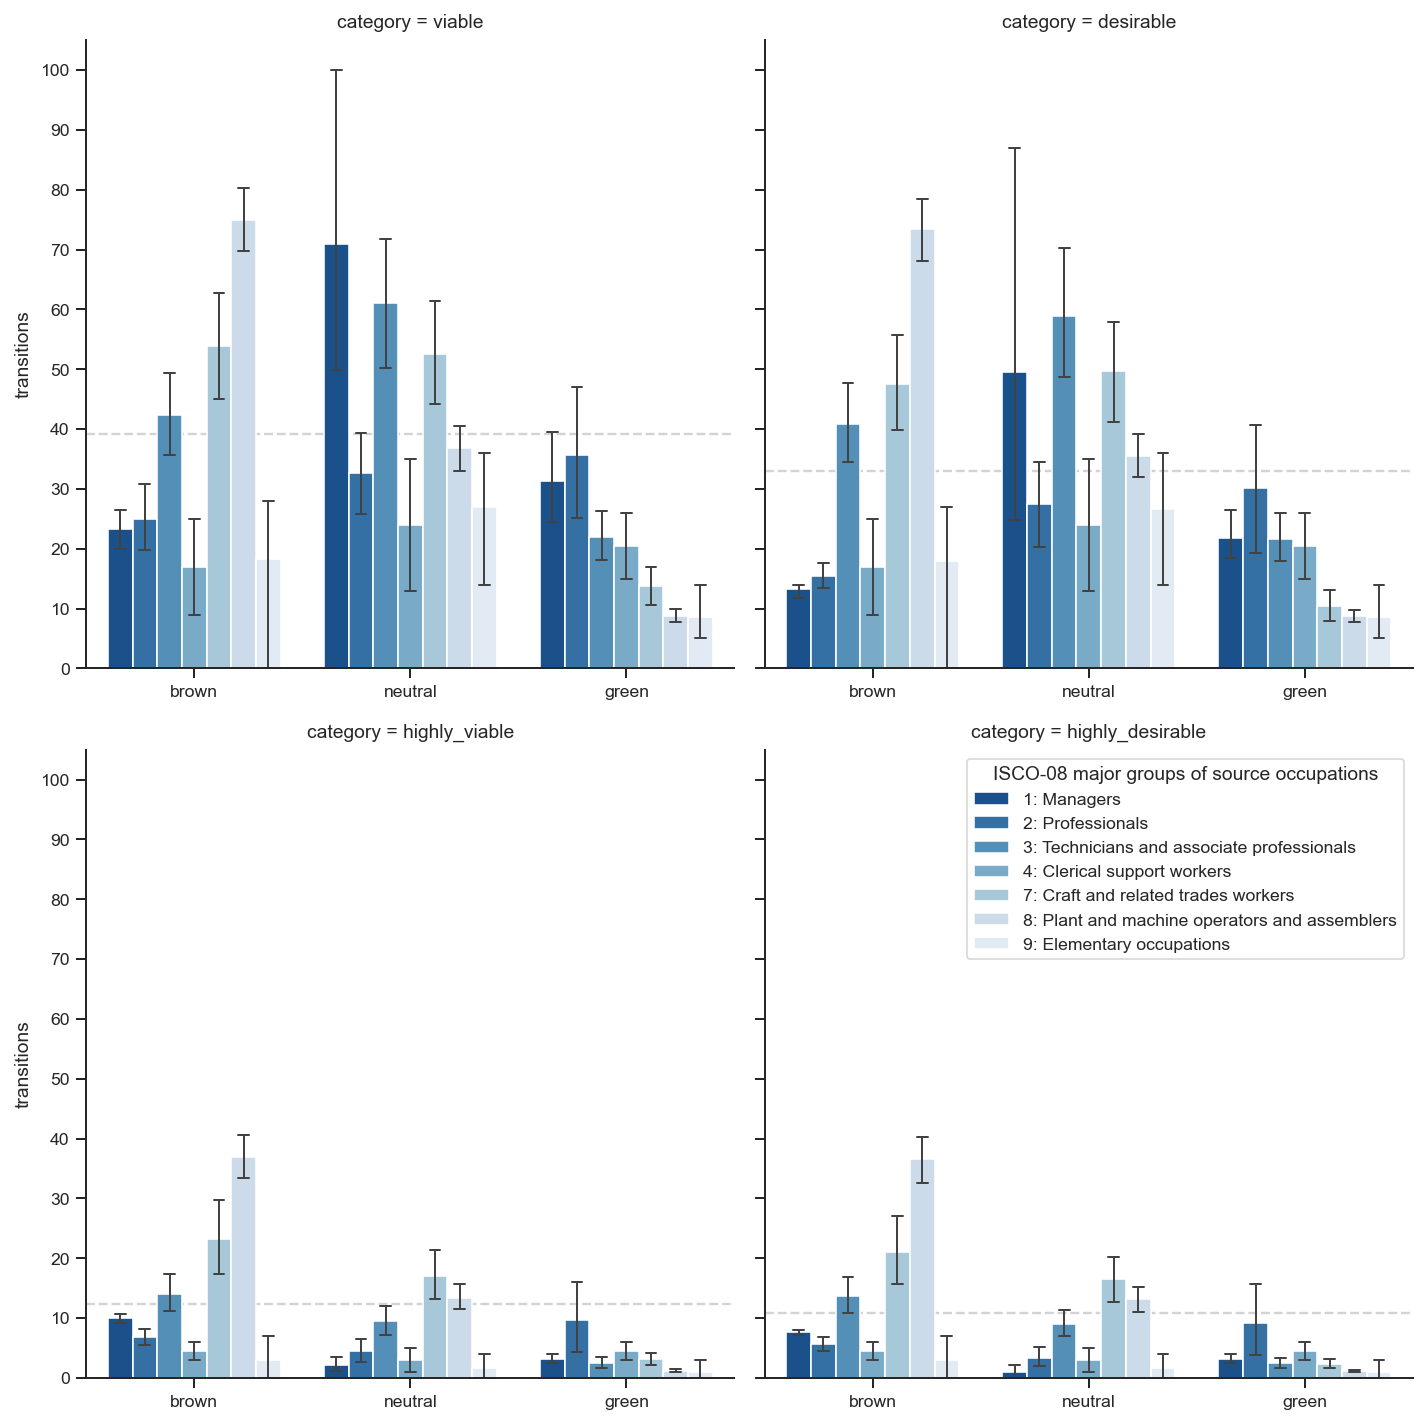

In [54]:
c = sns.catplot(
    y="transitions",
    x="target",
    hue="isco_level_1",
    col="category",
    col_wrap=2,
    kind="bar",
    order=["brown", "neutral", "green"],
    hue_order=new_labels_short,
    palette="Blues_r",
    ci=95,
    capsize=0.05,
    errwidth=1,
    sharex=False,
    height=5,
    aspect=1,
    legend=False,
    data=df_categories_long.query("(isco_level_1 != 5) & (isco_level_1 != 6)").replace({"isco_level_1": dict(zip(np.arange(1, 10), new_labels))})
)

for cat, ax in zip(transition_cats, c.axes):
    ax.set_ylim(0)
    ax.set_xlabel(None)
    ax.set_yticks(np.arange(0, 110, 10))

    ax.axhline(
    transition_cat_means[cat] / 3,
    linestyle="--",
    color="lightgrey",
    zorder=0
)

plt.tight_layout()
plt.legend(loc="best", title="ISCO-08 major groups of source occupations")

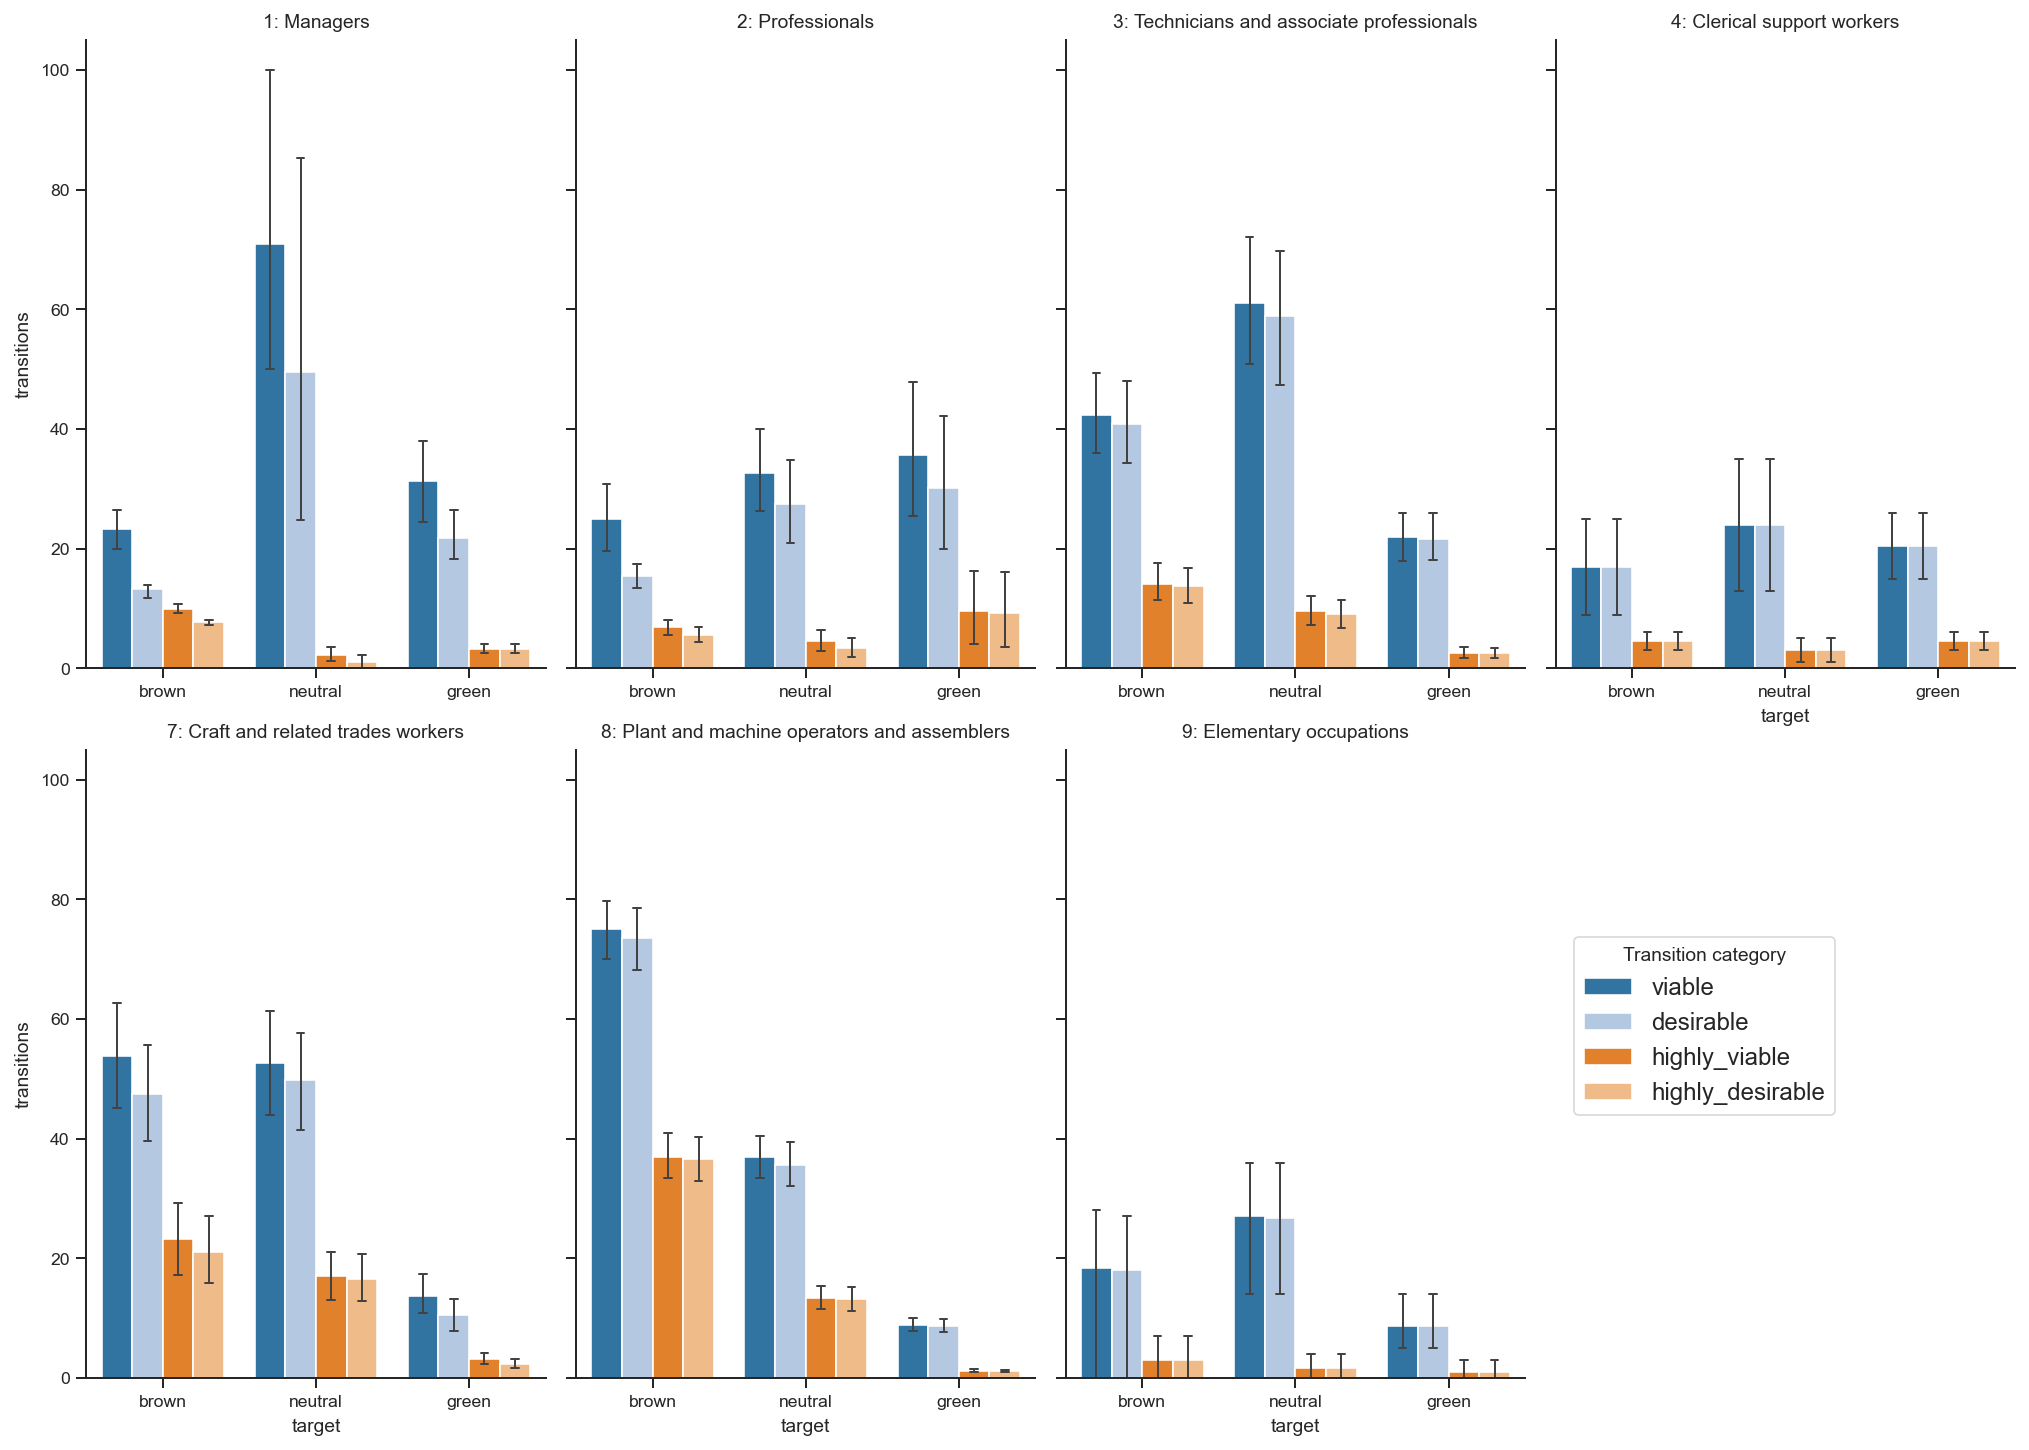

In [55]:
c = sns.catplot(
    y="transitions",
    x="target",
    hue="category",
    col="isco_level_1",
    col_wrap=4,
    kind="bar",
    #order=new_labels[0:4] + new_labels[6:9],
    order=["brown", "neutral", "green"],
    palette="tab20",
    ci=95,
    capsize=0.05,
    errwidth=1,
    sharex=False,
    height=5,
    aspect=0.7,
    legend=False,
    data=df_categories_long.query("(isco_level_1 != 5) & (isco_level_1 != 6)").replace({"isco_level_1": dict(zip(np.arange(1, 10), new_labels))}).sort_values("isco_level_1")
)

for i, ax in enumerate(c.axes):
    ax.set_title(new_labels_short[i])

plt.legend(loc="lower right", bbox_to_anchor=(1.7, 0.4), fontsize=12, title="Transition category")

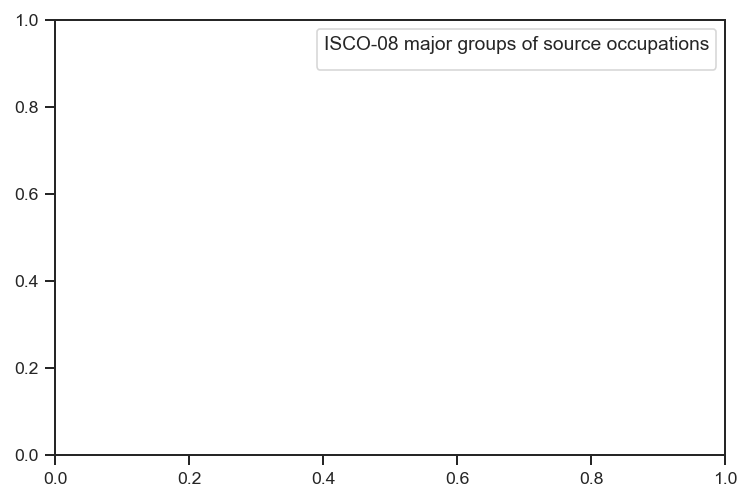

In [56]:
for cat, ax in zip(transition_cats, c.axes):
    ax.set_ylim(0)
    ax.set_xlabel(None)
    ax.set_yticks(np.arange(0, 110, 10))

    ax.axhline(
    transition_cat_means[cat] / 3,
    linestyle="--",
    color="lightgrey",
    zorder=0
)

plt.tight_layout()
plt.legend(loc="best", title="ISCO-08 major groups of source occupations")

In [57]:
# repeat for green and neutral occs to settle the mean / 3 question
df_metadata_transitions2_green = df_metadata_transitions2.query("occ_type == 'is_green'")

list_of_value_vars = [
    ["is_viable_brown", "is_viable_neutral", "is_viable_green"],
    ["is_highly_viable_brown", "is_highly_viable_neutral", "is_highly_viable_green"],
    ["is_desirable_brown", "is_desirable_neutral", "is_desirable_green"],
    ["is_highly_desirable_brown", "is_highly_desirable_neutral", "is_highly_desirable_green"],
]

list_of_df_categories = []

for i, value_vars in enumerate(list_of_value_vars):
    df_categories = df_metadata_transitions2_green.melt(
        value_vars=value_vars,
        value_name="transitions",
        var_name="target"
    )

    ids = pd.DataFrame(np.column_stack(list(zip(*df_categories.target.str.split("_")))))

    if (i % 2) == 0:
        df_categories["category"] = ids.iloc[:, 1]
        df_categories["target"] = ids.iloc[:, 2]
    else:
        df_categories["category"] = ids.iloc[:, 1] + "_" + ids.iloc[:, 2]
        df_categories["target"] = ids.iloc[:, 3]

    list_of_df_categories.append(df_categories)

df_categories_green_long = pd.concat(list_of_df_categories).reset_index(drop=True)

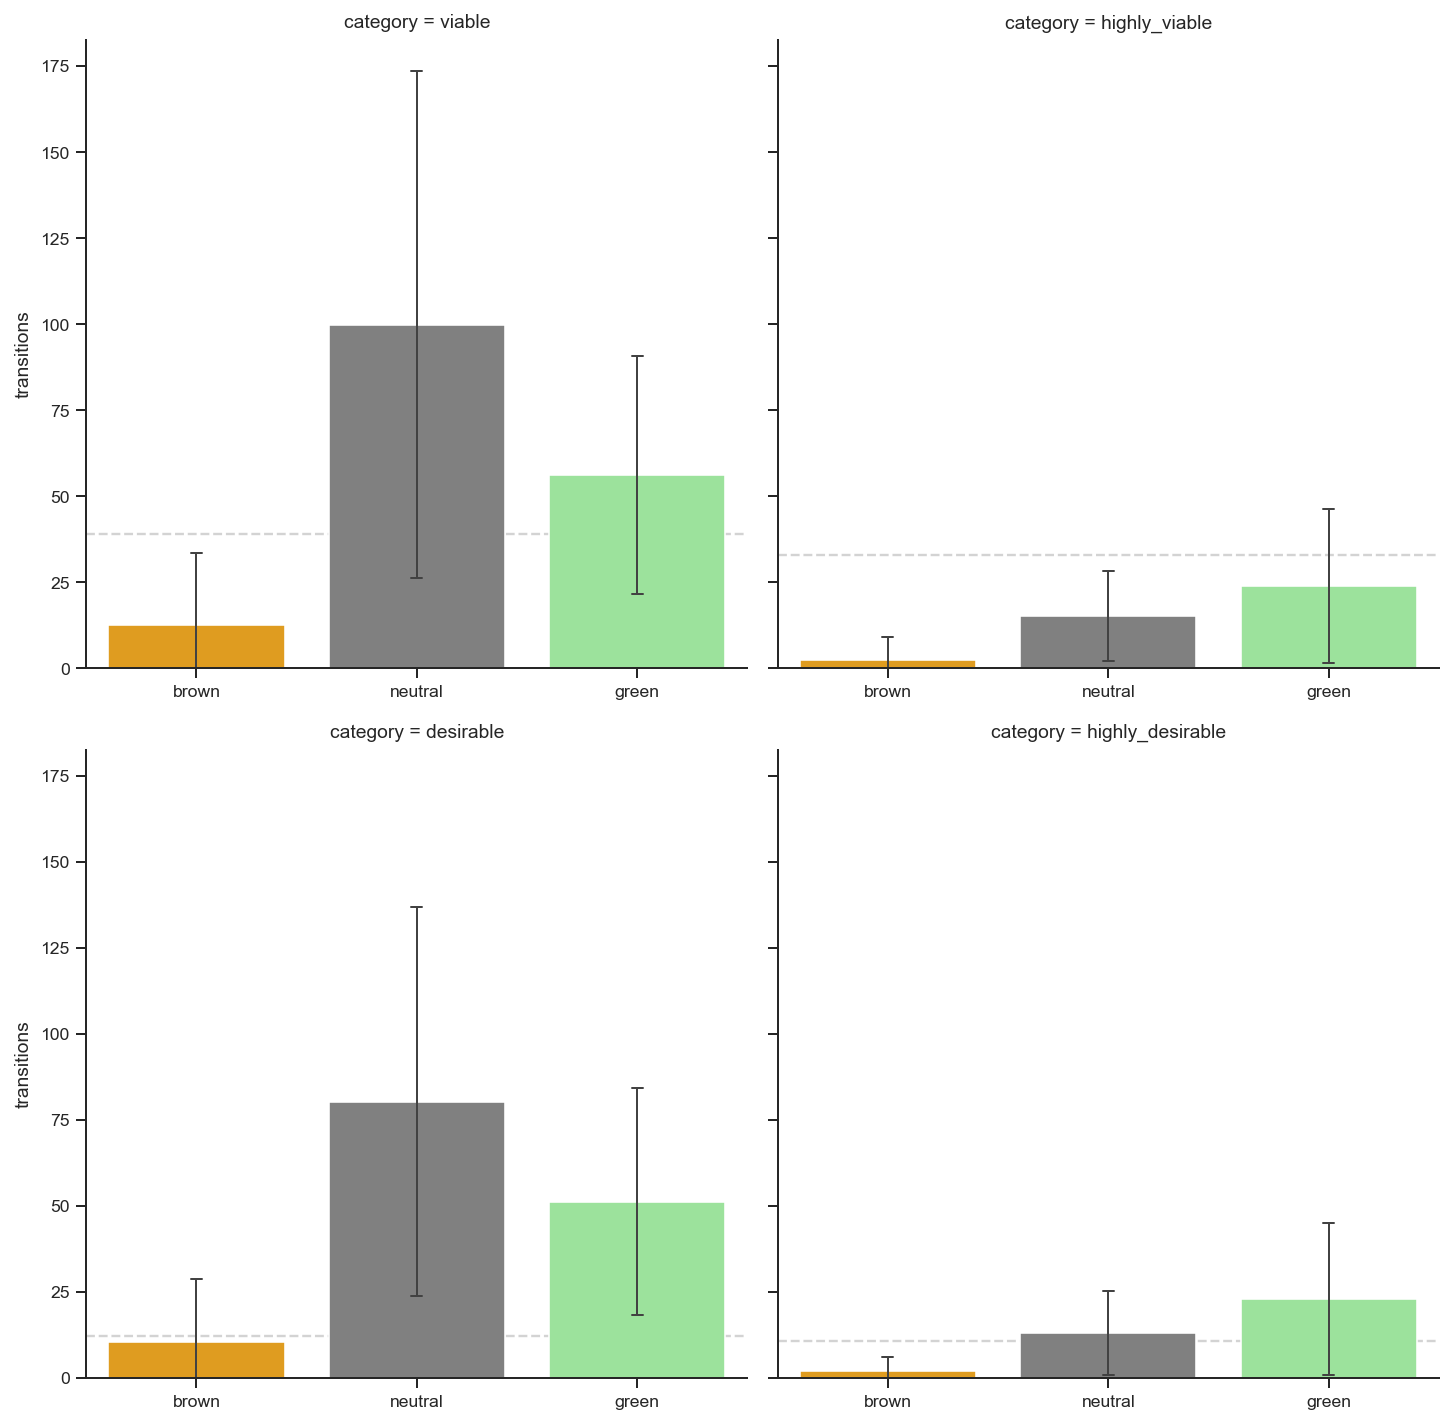

In [58]:
c = sns.catplot(
    y="transitions",
    x="target",
    col="category",
    col_wrap=2,
    kind="bar",
    order=["brown", "neutral", "green"],
    palette=["orange", "grey", "lightgreen"],
    ci="sd",
    capsize=0.05,
    errwidth=1,
    sharex=False,
    data=df_categories_green_long
)

for cat, ax in zip(transition_cats, c.axes):
    ax.set_ylim(0)
    ax.set_xlabel(None)
    #ax.set_yticks(np.arange(0, 110, 10))

    ax.axhline(
    transition_cat_means[cat] / 3,
    linestyle="--",
    color="lightgrey",
    zorder=0
)

#### Create a list of brown occupations with fewest transition options

In [59]:
df_metadata_transitions2_brown.sort_values("is_desirable").head(30)


,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce,is_brown,is_green,is_neutral,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_viable_brown,is_viable_neutral,is_viable_green,is_highly_viable_brown,is_highly_viable_neutral,is_highly_viable_green,is_desirable_brown,is_desirable_neutral,is_desirable_green,is_highly_desirable_brown,is_highly_desirable_neutral,is_highly_desirable_green,occ_type
1060,1066,http://data.europa.eu/esco/occupation/59207c91...,firework assembler,8219,47-5031.00,"explosives workers, ordnance handling experts,...",8,82,821,Non Green,NaN,NaN,NaN,NaN,0.000000,41.395976,29810.139535,0.000167,5356.0,2.0,2.4583,5.7500,5.0831,M,15000.0,565000.0,-500.0,-15000.0,564500.0,224000.0,14000.0,-367000.0,-224000.0,-353000.0,True,False,False,2,0,1,0,2,0,0,0,0,0,1,0,0,0,0,0,is_brown
1325,1331,http://data.europa.eu/esco/occupation/6f8f1da1...,recreation model maker,7522,51-7031.00,"model makers, wood",7,75,752,Non Green,NaN,NaN,NaN,NaN,0.000000,40.378983,24701.996269,0.000127,4088.0,3.0,2.2477,5.7608,4.9825,M,48000.0,316000.0,-500.0,-48000.0,315500.0,1315000.0,408000.0,-440000.0,-1315000.0,-32000.0,True,False,False,5,2,5,2,1,3,1,0,2,0,1,3,1,0,2,0,is_brown
198,199,http://data.europa.eu/esco/occupation/0fc6c577...,sectional belt mould assembler,8141,51-9041.00,"extruding, forming, pressing, and compacting m...",8,81,814,Non Green,NaN,NaN,NaN,NaN,0.000000,39.918182,24469.800000,NaN,NaN,2.0,2.5608,4.7591,3.8960,M,339000.0,712000.0,-34000.0,-339000.0,678000.0,2913000.0,500.0,-5589000.0,-2913000.0,-5588500.0,True,False,False,6,0,6,0,6,0,0,0,0,0,6,0,0,0,0,0,is_brown
1439,1446,http://data.europa.eu/esco/occupation/782ced63...,capsule filling machine operator,8131,51-9111.00,packaging and filling machine operators and te...,8,81,813,Non Green,NaN,NaN,NaN,NaN,0.000000,39.965625,22211.820144,0.000053,1699.0,2.0,1.9021,3.7702,2.6640,M,339000.0,712000.0,-34000.0,-339000.0,678000.0,2913000.0,500.0,-5589000.0,-2913000.0,-5588500.0,True,False,False,11,0,11,0,9,2,0,0,0,0,9,2,0,0,0,0,is_brown
1710,1718,http://data.europa.eu/esco/occupation/8f9b20ff...,automated cable vehicle controller,8343,53-7041.00,hoist and winch operators,8,83,834,Non Green,NaN,NaN,NaN,NaN,0.000000,38.918305,23801.455000,0.000272,8741.0,2.0,2.1391,5.9754,4.9077,M,329000.0,810000.0,-33000.0,-329000.0,777000.0,2899000.0,753000.0,-2612000.0,-2899000.0,-1859000.0,True,False,False,12,0,11,0,0,11,1,0,0,0,0,10,1,0,0,0,is_brown
1751,1759,http://data.europa.eu/esco/occupation/949bccd9...,wicker furniture maker,7317,51-7021.00,furniture finishers,7,73,731,Non Green,NaN,NaN,NaN,NaN,0.000000,38.835000,23833.750000,0.000064,2046.0,2.0,1.6771,5.5099,4.2003,M,27000.0,310000.0,-500.0,-27000.0,309500.0,1331000.0,35000.0,-1057000.0,-1331000.0,-1022000.0,True,False,False,11,4,11,4,7,4,0,3,1,0,7,4,0,3,1,0,is_brown
1604,1611,http://data.europa.eu/esco/occupation/86c49d9c...,roustabout,8113,47-5071.00,"roustabouts, oil and gas",8,81,811,Non Green,NaN,NaN,NaN,NaN,0.000000,38.261947,26037.989011,0.000021,680.0,1.0,1.7165,2.7936,2.9478,M,339000.0,712000.0,-34000.0,-339000.0,678000.0,2913000.0,500.0,-5589000.0,-2913000.0,-5588500.0,True,False,False,13,1,13,1,5,8,0,1,0,0,5,8,0,1,0,0,is_brown
830,834,http://data.europa.eu/esco/occupation/46bbecf4...,well-digger,8113,47-5021.00,"earth drillers, except oil and gas",8,81,811,Non Green,NaN,NaN,NaN,NaN,0.000000,38.261947,26037.989011,0.000021

#### Job zone statistics by occ type

In [60]:
df_metadata_transitions2[["occ_type", "job_zone"]].groupby("occ_type").aggregate(["median", "mean", "std"])

job_zone                    
             median      mean       std
occ_type                               
is_brown        2.0  2.251908  0.662519
is_green        4.0  3.525000  0.784802
is_neutral      3.0  3.210450  1.084399

In [61]:
test = df_metadata_transitions2.copy()
test["count"] = 1
test[["occ_type", "job_zone", "count"]].groupby(["job_zone", "occ_type"]).count()

count
job_zone occ_type         
1.0      is_brown        8
         is_neutral     62
2.0      is_brown      319
         is_green       61
         is_neutral    579
3.0      is_brown       25
         is_green       80
         is_neutral    566
4.0      is_brown       41
         is_green      247
         is_neutral    582
5.0      is_green       12
         is_neutral    278

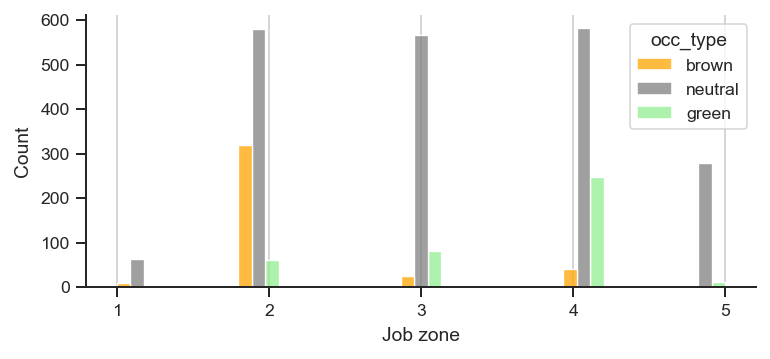

In [62]:
#sns.set_style("ticks", {'axes.grid': True, "grid.linestyle": "--"})

fig, ax = plt.subplots(figsize=(6, 2.5))

sns.histplot(
    x="job_zone",
    hue="occ_type",
    multiple="dodge",
    stat="count",
    hue_order=["brown", "neutral", "green"],
    palette=["orange", "grey", "lightgreen"],
    data=df_metadata_transitions2.replace(replace_dict["occ_type"]),
    ax=ax
)

ax.xaxis.grid()
ax.set_xlabel("Job zone")
ax.set_xticks(np.arange(1, 6))
#ax.set_yticks(np.arange(100, 700, 100))
sns.despine()